## Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os

# Machine Learning Imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform, randint
from sklearn.svm import SVR

# Time Series Analysis Imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Plotting (Optional)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# type: ignore
# --- TensorFlow / Keras Imports ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, concatenate # Added specific layers

## Config

In [3]:
# --- Configuration ---
WEATHER_DATA_PATH = "synthetic_weather_data.csv"
OPERATIONS_DATA_PATH = "synthetic_operations_log.csv"
# !!! Start date used for weather generation !!!
SIMULATION_START_DATE = "2023-01-01"

# --- Feature Engineering Parameters ---
FORECAST_HORIZON_HOURS = 48  # How many hours of weather forecast to use as features
TIME_WINDOWS = [6, 12, 24, 48]  # Summary windows for weather features (in hours)
TARGET_COLUMN = "total_weather_delay_hrs"

## Loading

In [4]:
# --- Load Data ---
print("Loading data...")
weather_df = pd.read_csv(WEATHER_DATA_PATH, index_col=0, parse_dates=True)
ops_df = pd.read_csv(OPERATIONS_DATA_PATH)
print(f"Loaded {len(weather_df)} weather records and {len(ops_df)} operations records.")

Loading data...
Loaded 9481 weather records and 6447 operations records.


## EDA

In [5]:
# --- Config for EDA ---
# Set plot style for the notebook session
plt.style.use('seaborn-v0_8-whitegrid')
# Ensure plots appear inline in Jupyter
%matplotlib inline
# Adjust default figure size for better readability in notebooks
plt.rcParams['figure.figsize'] = (10, 6)


In [6]:
print("\n--- Weather Data Preview ---")
weather_df.info()
display(weather_df.head())  # Use display() in notebooks
display(weather_df.describe())


--- Weather Data Preview ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9481 entries, 2023-01-01 00:00:00 to 2024-01-31 00:00:00
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state               9481 non-null   object 
 1   wind_speed_knots    9481 non-null   float64
 2   visibility_nm       9481 non-null   float64
 3   precipitation_mmhr  9481 non-null   float64
 4   wave_height_m       9481 non-null   float64
 5   wind_direction_deg  9481 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 518.5+ KB


,state,wind_speed_knots,visibility_nm,precipitation_mmhr,wave_height_m,wind_direction_deg
2023-01-01 00:00:00,Clear,4.950726,9.912644,0.0,0.363862,270
2023-01-01 01:00:00,Clear,5.394664,9.309864,0.0,0.410227,270
2023-01-01 02:00:00,Clear,3.355598,9.978494,0.0,0.700904,225
2023-01-01 03:00:00,Clear,4.239369,9.686718,0.0,0.602303,225
2023-01-01 04:00:00,Clear,5.210675,8.532144,0.0,0.574423,315


,wind_speed_knots,visibility_nm,precipitation_mmhr,wave_height_m,wind_direction_deg
count,9481.000000,9481.000000,9481.000000,9481.000000,9481.000000
mean,6.228859,7.977231,0.321355,0.997964,201.856872
std,5.945363,2.930760,1.434669,0.816773,98.754926
min,0.039860,0.000090,0.000000,0.100000,0.000000
25%,2.577104,7.974657,0.000000,0.515111,135.000000
50%,4.557046,9.293251,0.000000,0.747841,225.000000
75%,7.502445,9.723092,0.000000,1.149150,270.000000
max,54.048715,9.999889,26.606056,10.365446,315.000000


In [7]:
print("\n--- Operations Data Preview ---")
ops_df.info()
display(ops_df.head())
key_ops_metrics = [
    "teu",
    "total_time_hrs",
    "berth_time_hrs",
    "berth_wait_time_hrs",
    "weather_delay_entry_hrs",
    "weather_delay_berthing_hrs",
    "cargo_ops_weather_delay_hrs",
    "total_weather_delay_hrs",
]
key_ops_metrics_present = [col for col in key_ops_metrics if col in ops_df.columns]
if key_ops_metrics_present:
    display(ops_df[key_ops_metrics_present].describe())
else:
    print("Key operational metrics not found.")


--- Operations Data Preview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6447 entries, 0 to 6446
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   vessel_id                    6447 non-null   object 
 1   type                         6447 non-null   object 
 2   teu                          6447 non-null   float64
 3   arrival_time                 6447 non-null   float64
 4   entry_permit_time            6447 non-null   float64
 5   weather_delay_entry_hrs      6447 non-null   float64
 6   berth_wait_time_hrs          6447 non-null   float64
 7   weather_delay_berthing_hrs   6447 non-null   float64
 8   berth_start_time             6447 non-null   float64
 9   berth_end_time               6447 non-null   float64
 10  cargo_ops_weather_delay_hrs  6447 non-null   float64
 11  departure_time               6447 non-null   float64
 12  total_time_hrs               6447 non-null 

,vessel_id,type,teu,arrival_time,entry_permit_time,weather_delay_entry_hrs,berth_wait_time_hrs,weather_delay_berthing_hrs,berth_start_time,berth_end_time,cargo_ops_weather_delay_hrs,departure_time,total_time_hrs,berth_time_hrs,total_weather_delay_hrs
0,V_11,Container_Panamax,4556.146989,20.498637,20.498637,0.0,0.0,0.0,21.998637,68.560107,1.0,70.060107,49.561470,46.561470,1.0
1,V_10,Container_Panamax,5231.137134,17.557721,17.557721,0.0,0.0,0.0,19.057721,72.369092,1.0,73.869092,56.311371,53.311371,1.0
2,V_19,Container_Panamax,5621.383849,34.091194,34.091194,0.0,0.0,0.0,35.591194,92.805033,1.0,94.305033,60.213838,57.213838,1.0
3,V_2,Container_PostPanamax,8537.300710,9.672448,9.672448,0.0,0.0,0.0,11.172448,97.545455,1.0,99.045455,89.373007,86.373007,1.0
4,V_25,Container_Panamax,5438.132235,43.786674,43.786674,0.0,0.0,0.0,45.286674,99.667997,0.0,101.167997,57.381322,54.381322,0.0


,teu,total_time_hrs,berth_time_hrs,berth_wait_time_hrs,weather_delay_entry_hrs,weather_delay_berthing_hrs,cargo_ops_weather_delay_hrs,total_weather_delay_hrs
count,6447.000000,6447.000000,6447.000000,6447.000000,6447.000000,6447.000000,6447.000000,6447.000000
mean,12096.564410,124.441763,121.288430,0.000394,0.140220,0.012719,0.322786,0.475725
std,5277.399867,52.925802,52.927845,0.017112,0.498717,0.121372,0.686884,0.865618
min,3416.334151,37.163342,34.163342,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8704.798814,90.453770,87.282439,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10631.469100,109.699519,106.456309,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17397.646028,177.542618,174.414818,0.000000,0.000000,0.000000,0.000000,1.000000
max,24126.866274,245.268663,242.268663,1.003075,6.000000,2.000000,4.000000,7.000000


### Weather Data EDA - Distributions and States


--- 1. Analyzing Weather Data (`weather_df`) ---

Weather Time Series Check:
Index is monotonic increasing: True
Inferred Frequency: h
Cannot automatically check for missing timestamps (frequency not 'H').

Plotting Weather Variable Distributions...


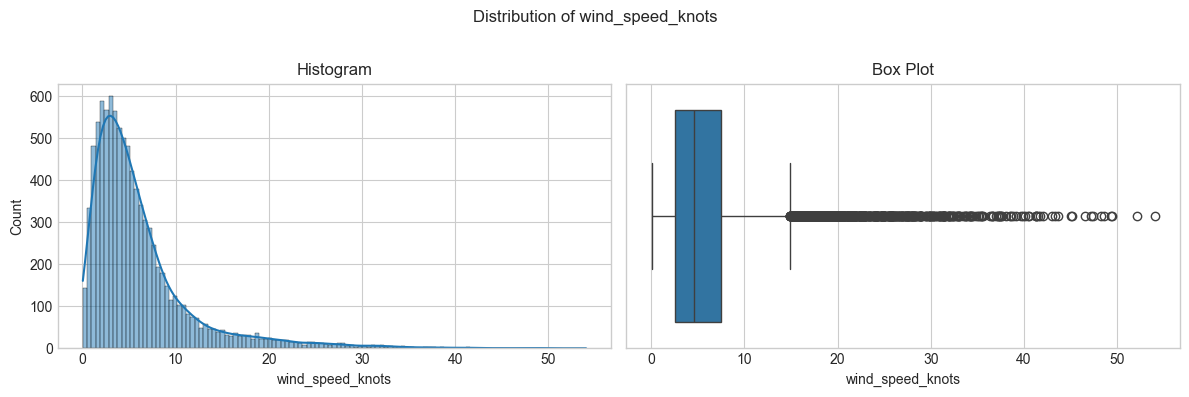

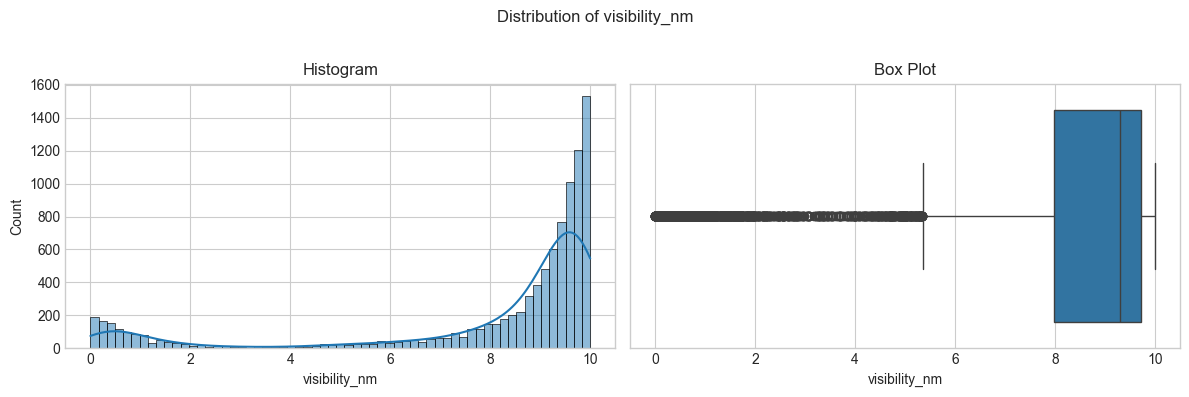

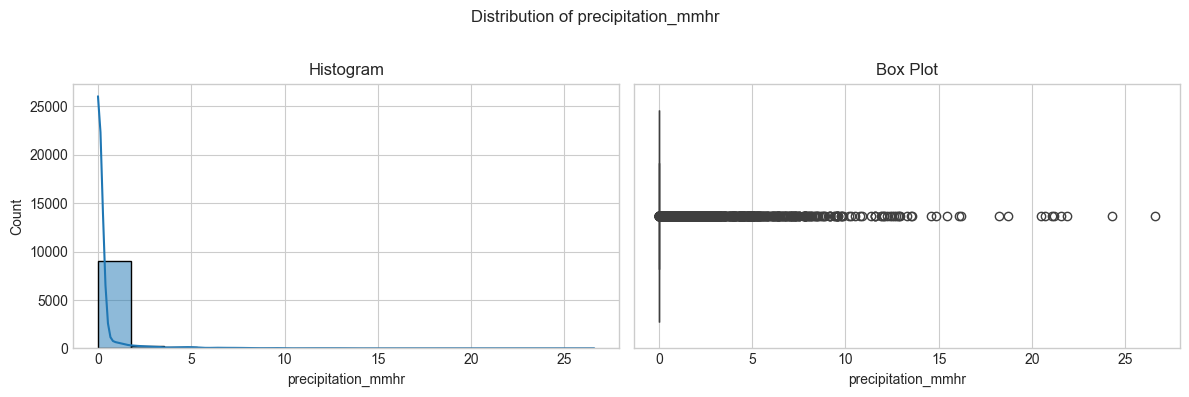

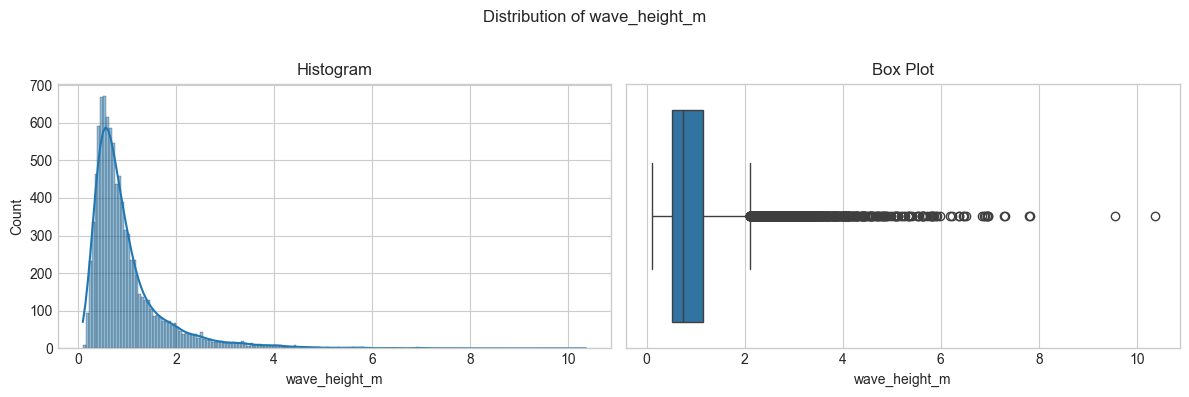

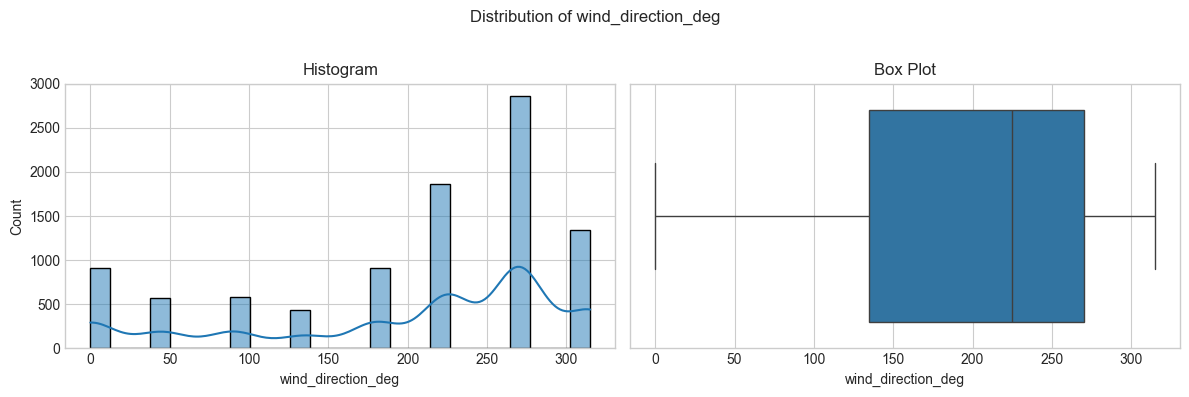


Analyzing Weather States...


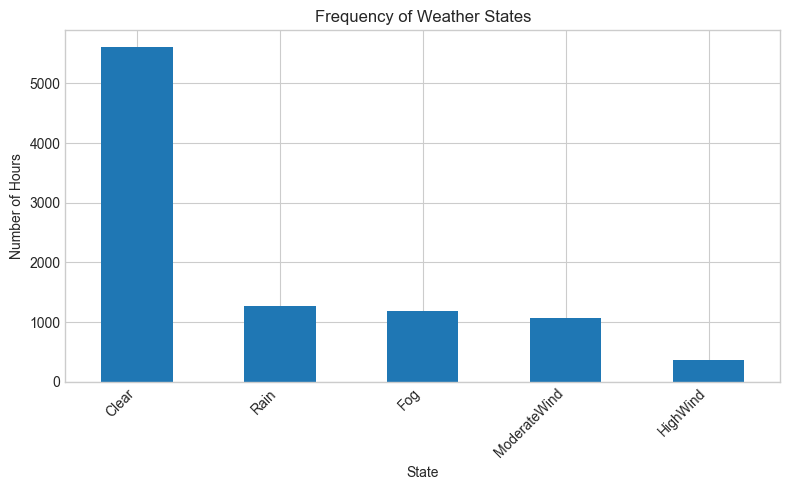


Weather State Counts:
state
Clear           5608
Rain            1271
Fog             1184
ModerateWind    1060
HighWind         358
Name: count, dtype: int64


In [8]:
if "weather_df" not in locals():
    print("Weather data not loaded. Skipping Weather EDA.")
else:
    print("\n--- 1. Analyzing Weather Data (`weather_df`) ---")

    # Time Series Properties
    print("\nWeather Time Series Check:")
    print(f"Index is monotonic increasing: {weather_df.index.is_monotonic_increasing}")
    inferred_freq = pd.infer_freq(weather_df.index)  # type: ignore
    print(f"Inferred Frequency: {inferred_freq}")
    if inferred_freq == "H":
        expected_range = pd.date_range(
            start=weather_df.index.min(), end=weather_df.index.max(), freq="H"
        )
        missing_timestamps = expected_range.difference(weather_df.index)
        print(f"Number of missing hourly timestamps: {len(missing_timestamps)}")
    else:
        print("Cannot automatically check for missing timestamps (frequency not 'H').")

    # Distribution of Numerical Weather Variables
    print("\nPlotting Weather Variable Distributions...")
    numerical_weather_cols = weather_df.select_dtypes(include=np.number).columns
    for col in numerical_weather_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"Distribution of {col}")
        sns.histplot(weather_df[col], kde=True, ax=axes[0])  # type: ignore
        axes[0].set_title("Histogram")
        sns.boxplot(x=weather_df[col], ax=axes[1])
        axes[1].set_title("Box Plot")
        plt.tight_layout(rect=(0, 0, 1, 0.96))  # Adjust layout
        plt.show()  # Display the plot inline

    # Weather State Analysis (if 'state' column exists)
    if "state" in weather_df.columns:
        print("\nAnalyzing Weather States...")
        fig, ax = plt.subplots(figsize=(8, 5))
        state_counts = weather_df["state"].value_counts()
        state_counts.plot(kind="bar", ax=ax)
        ax.set_title("Frequency of Weather States")
        ax.set_ylabel("Number of Hours")
        ax.set_xlabel("State")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        print("\nWeather State Counts:")
        print(state_counts)
    else:
        print("\n'state' column not found in weather data.")

### Weather Data EDA - Correlations and Time Series Plots


Plotting Weather Variable Correlation Matrix...


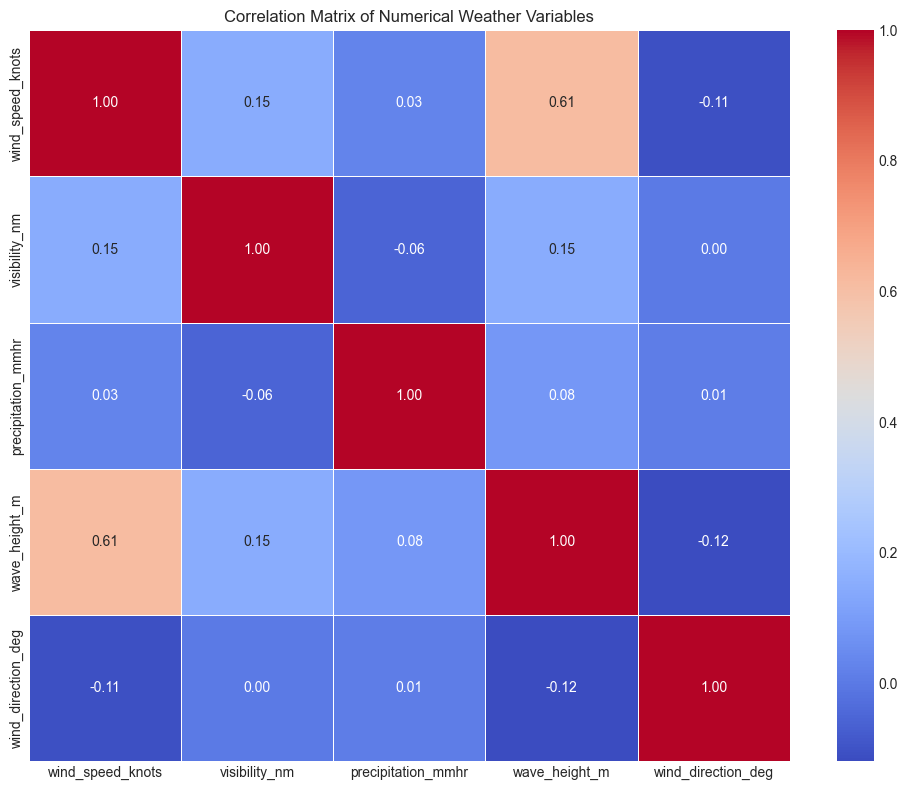


Plotting Weather Variables Over Time (Sample)...


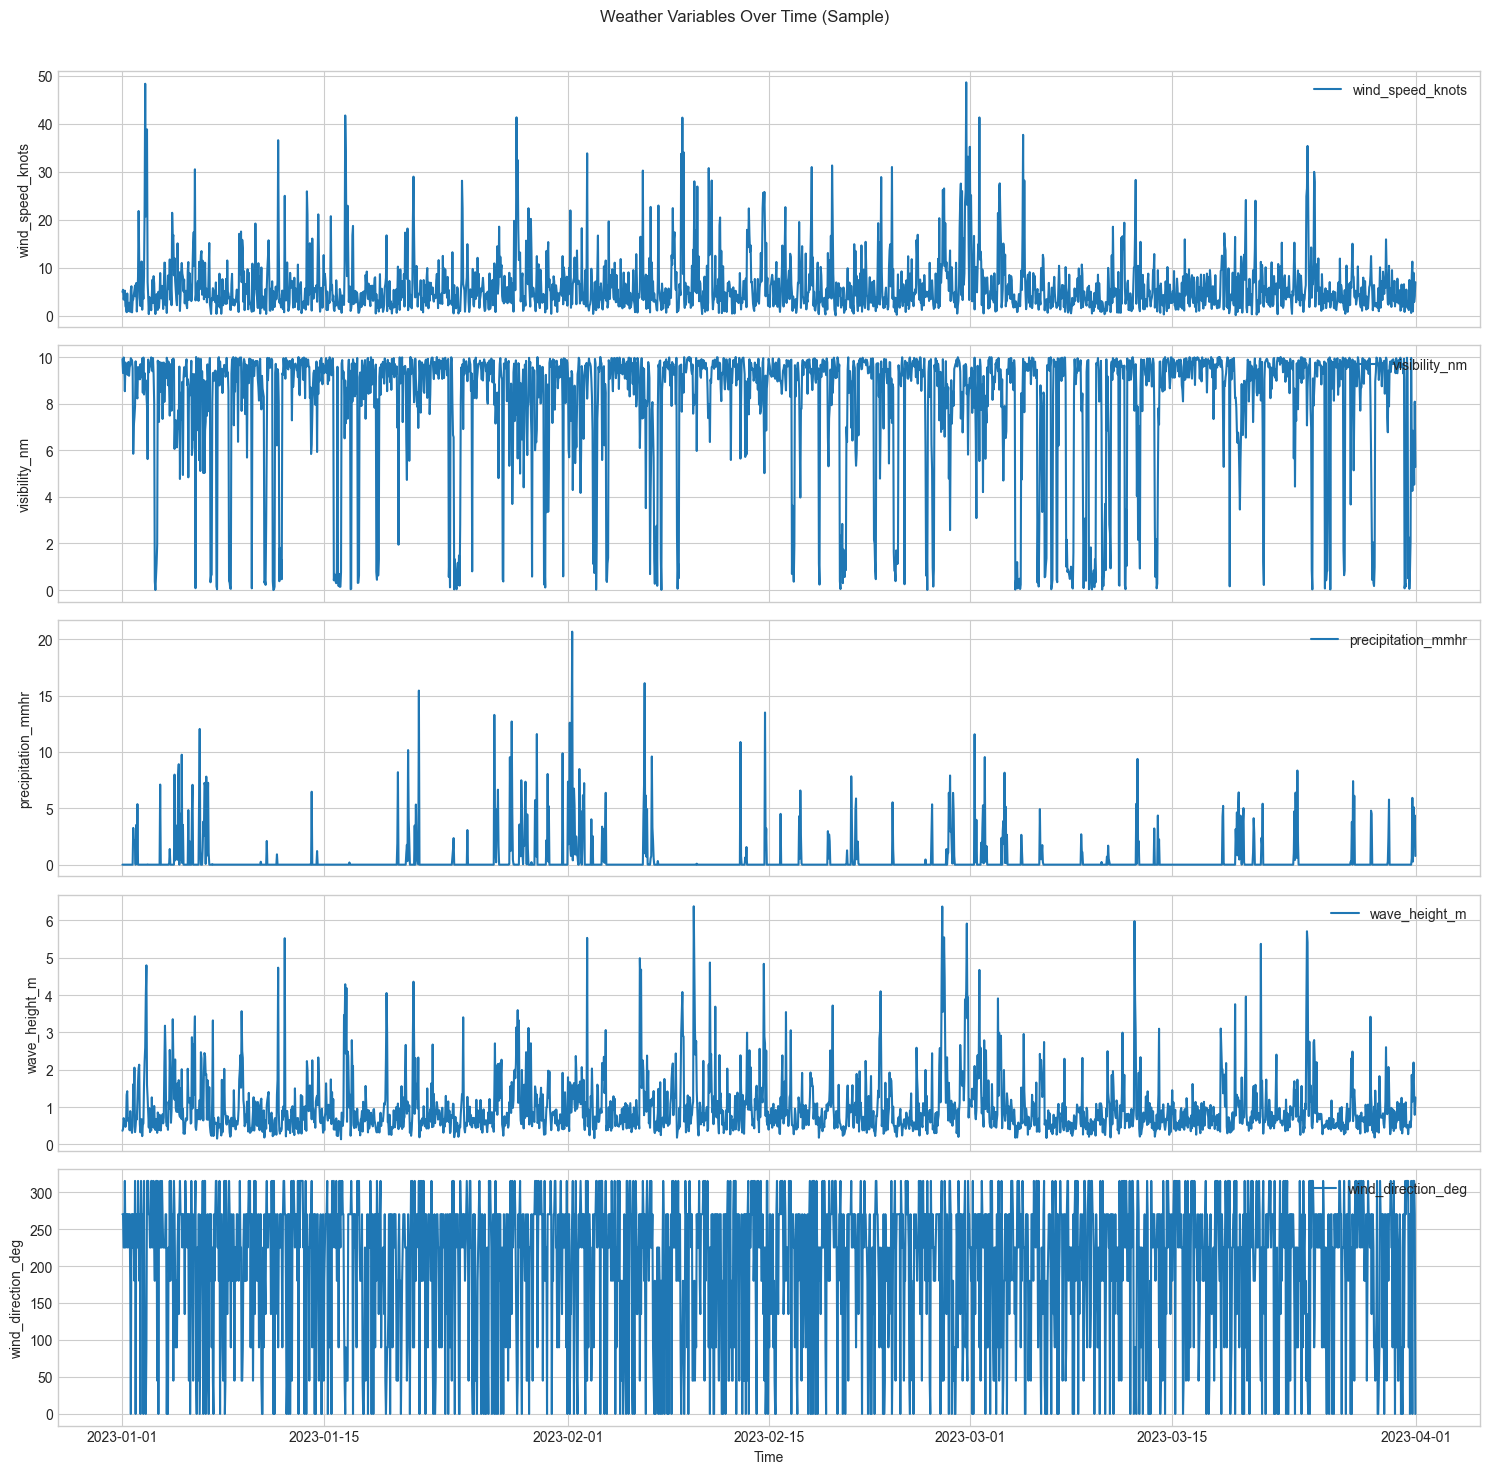

In [9]:
if "weather_df" not in locals():
    print("Weather data not loaded. Skipping Weather EDA.")
else:
    # Correlation Matrix for Numerical Weather Variables
    print("\nPlotting Weather Variable Correlation Matrix...")
    numerical_weather_cols = weather_df.select_dtypes(include=np.number).columns
    if len(numerical_weather_cols) > 1:
        correlation_matrix = weather_df[numerical_weather_cols].corr()
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(
            correlation_matrix,
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5,
            ax=ax,
        )
        ax.set_title("Correlation Matrix of Numerical Weather Variables")
        plt.tight_layout()
        plt.show()
    else:
        print("  Not enough numerical columns for correlation matrix.")

    # Time Series Plots (Plot subset for clarity if data is very long)
    print("\nPlotting Weather Variables Over Time (Sample)...")
    plot_subset_days = 90  # Plot approx 3 months
    inferred_freq = pd.infer_freq(weather_df.index)  # Re-check freq # type: ignore
    subset_end_index = min(
        len(weather_df) - 1,
        int(plot_subset_days * 24 / (1 if inferred_freq == "H" else 1)),
    )  # Adjust if not hourly
    weather_subset = weather_df.iloc[:subset_end_index]

    cols_to_plot = numerical_weather_cols  # Plot all numerical
    if len(cols_to_plot) > 0:
        n_plots = len(cols_to_plot)
        fig, axes = plt.subplots(n_plots, 1, figsize=(15, n_plots * 3), sharex=True)
        if n_plots == 1:
            axes = [axes]  # Make it iterable if only one plot
        fig.suptitle("Weather Variables Over Time (Sample)")
        for i, col in enumerate(cols_to_plot):
            axes[i].plot(weather_subset.index, weather_subset[col], label=col)
            axes[i].set_ylabel(col)
            axes[i].legend(loc="upper right")
            axes[i].grid(True)
        axes[-1].set_xlabel("Time")
        plt.tight_layout(rect=(0, 0, 1, 0.97))  # Adjust layout
        plt.show()
    else:
        print("  No numerical columns found to plot time series.")

### Operations Data EDA - Distributions


--- 2. Analyzing Operations Data (`ops_df`) ---

Plotting Operational Metric Distributions...


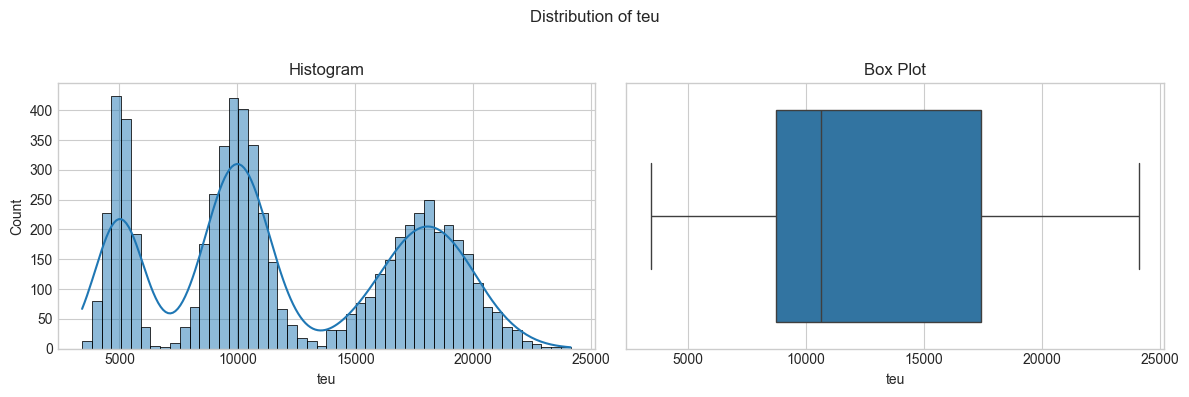

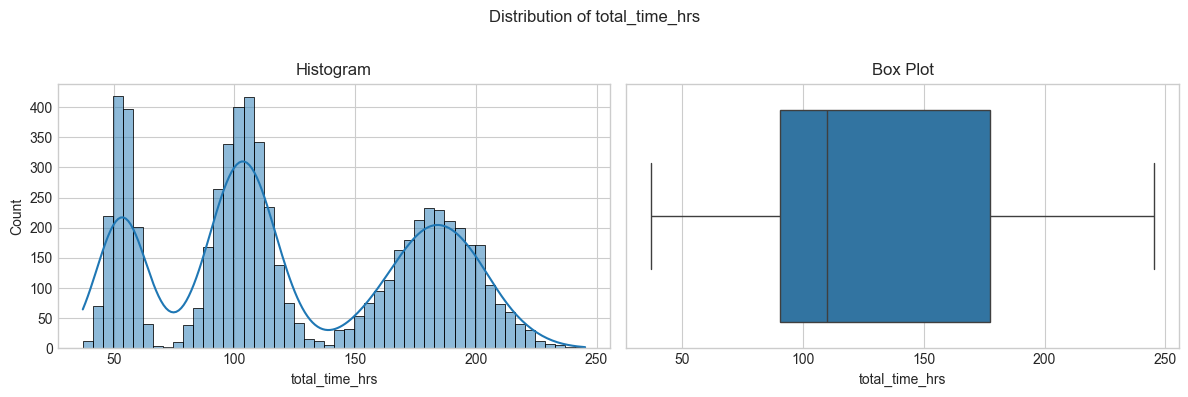

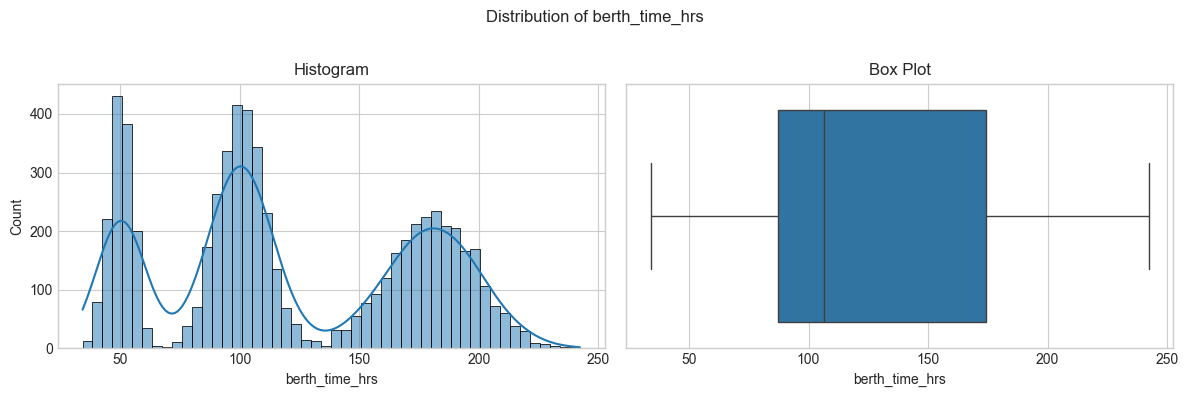

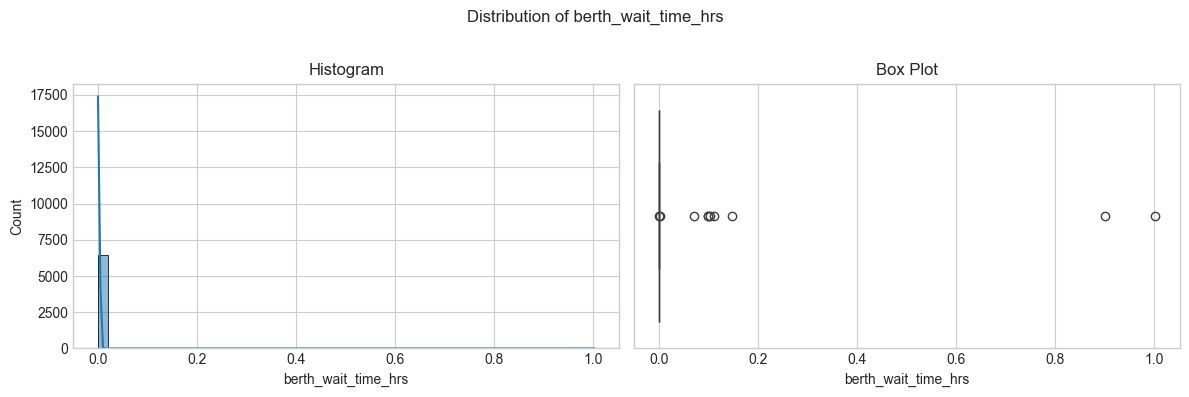

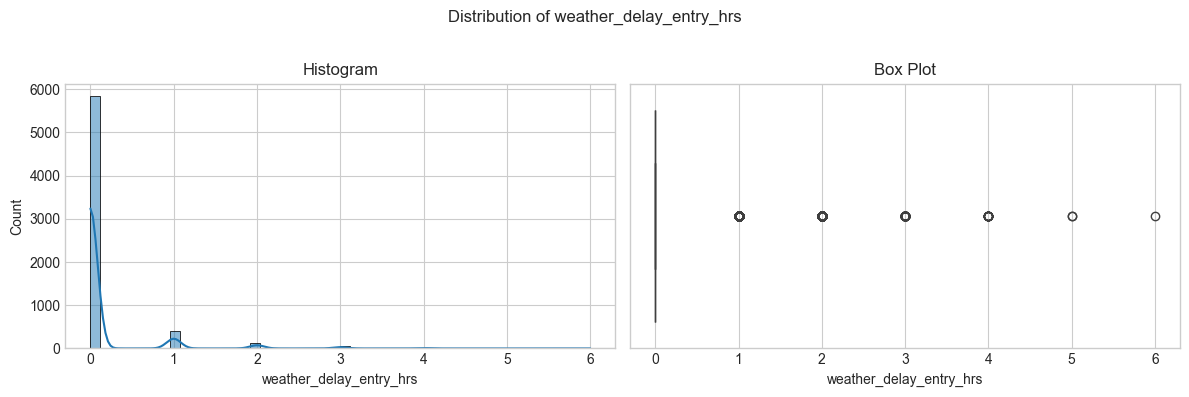

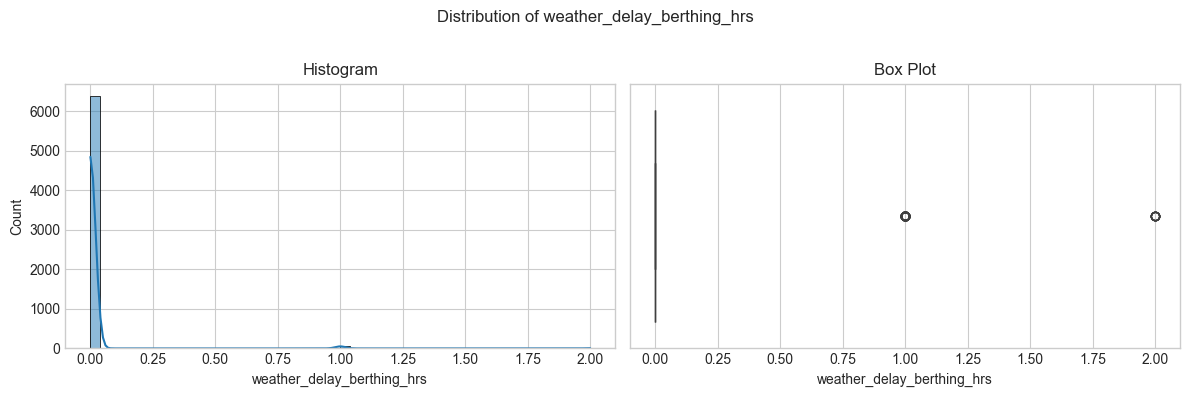

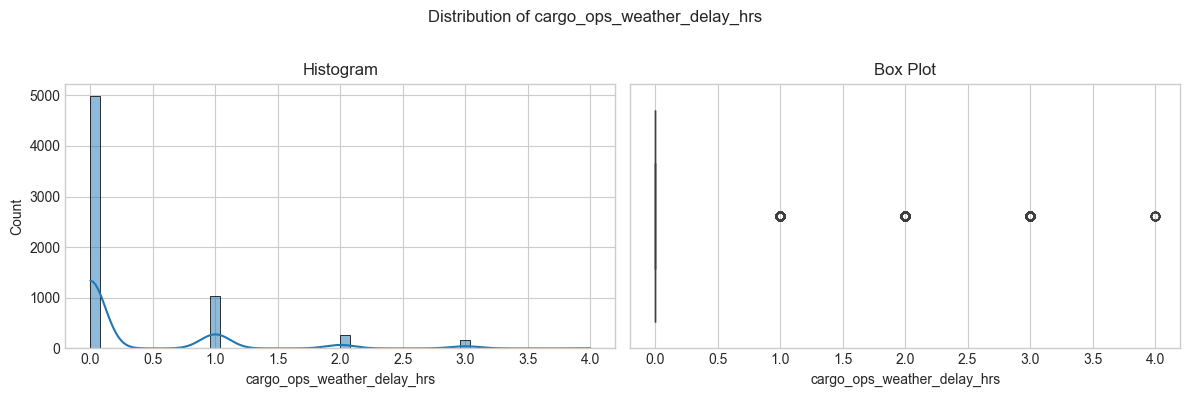

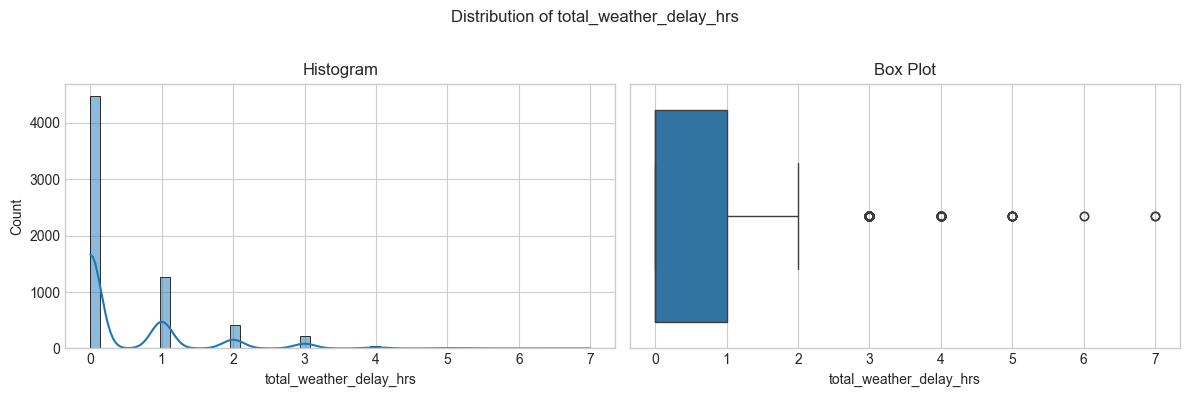


Plotting Vessel Type Distribution...


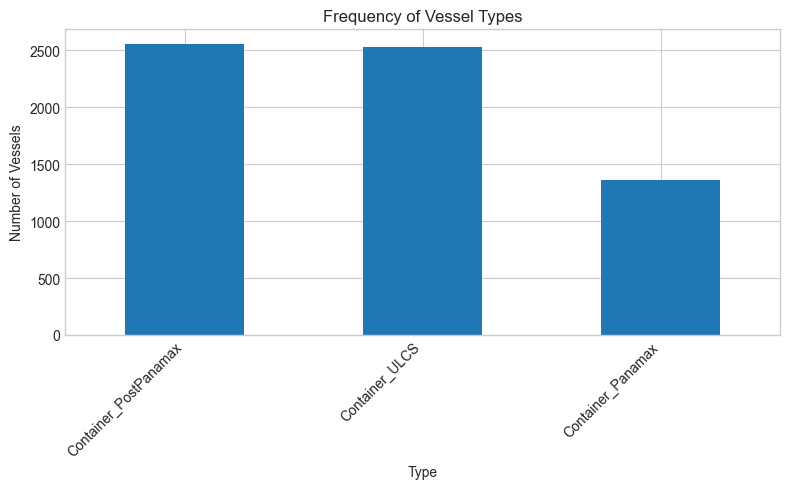


Vessel Type Counts:
type
Container_PostPanamax    2557
Container_ULCS           2528
Container_Panamax        1362
Name: count, dtype: int64


In [10]:
if "ops_df" not in locals():
    print("Operations data not loaded. Skipping Operations EDA.")
else:
    print("\n--- 2. Analyzing Operations Data (`ops_df`) ---")

    # Distribution of Key Numerical Operational Metrics
    print("\nPlotting Operational Metric Distributions...")
    key_ops_metrics = [
        "teu",
        "total_time_hrs",
        "berth_time_hrs",
        "berth_wait_time_hrs",
        "weather_delay_entry_hrs",
        "weather_delay_berthing_hrs",
        "cargo_ops_weather_delay_hrs",
        "total_weather_delay_hrs",
    ]
    key_ops_metrics_present = [col for col in key_ops_metrics if col in ops_df.columns]

    for col in key_ops_metrics_present:
        # Skip delay columns if they are potentially all zero
        if "delay" in col and ops_df[col].max() <= 0:  # Use <= 0 to be safe
            print(
                f"  Skipping plot for '{col}' as values are likely all zero or negative."
            )
            continue
        if ops_df[col].isnull().all():
            print(f"  Skipping plot for '{col}' as all values are missing.")
            continue

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"Distribution of {col}")
        sns.histplot(ops_df[col].dropna(), kde=True, ax=axes[0], bins=50)  # type: ignore
        axes[0].set_title("Histogram")
        sns.boxplot(x=ops_df[col].dropna(), ax=axes[1])
        axes[1].set_title("Box Plot")
        plt.tight_layout(rect=(0, 0, 1, 0.96))
        plt.show()

    # Distribution of Categorical Features (e.g., Vessel Type)
    if "type" in ops_df.columns:
        print("\nPlotting Vessel Type Distribution...")
        fig, ax = plt.subplots(figsize=(8, 5))
        type_counts = ops_df["type"].value_counts()
        type_counts.plot(kind="bar", ax=ax)
        ax.set_title("Frequency of Vessel Types")
        ax.set_ylabel("Number of Vessels")
        ax.set_xlabel("Type")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        print("\nVessel Type Counts:")
        print(type_counts)
    else:
        print("\n'type' column not found in operations data.")

### Relating Weather and Operations


--- 3. Analyzing Relationships Between Weather and Operations ---
  Adding arrival timestamps to operations data...
  Analyzing delays based on weather state at arrival...


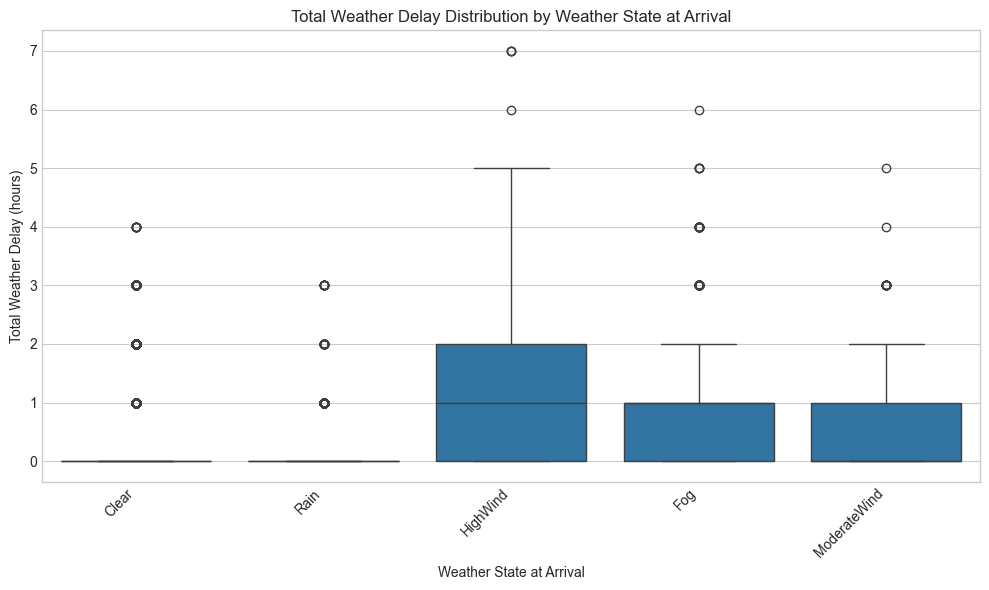


  Plotting aggregated daily delays vs. adverse weather hours...


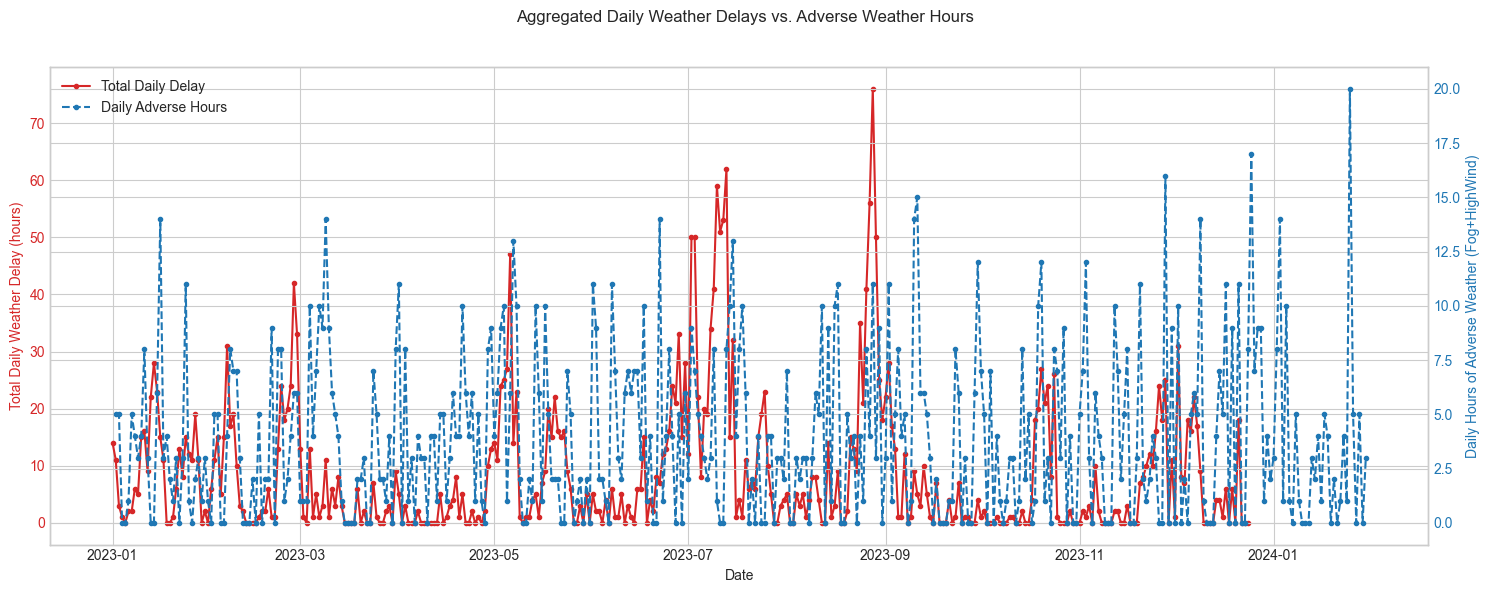


--- EDA Finished ---


In [11]:
print("\n--- 3. Analyzing Relationships Between Weather and Operations ---")

# Add arrival timestamp to ops_df for alignment (ensure it's not added multiple times)
if "arrival_timestamp" not in ops_df.columns:
    print("  Adding arrival timestamps to operations data...")
    base_datetime = pd.to_datetime(SIMULATION_START_DATE)
    ops_df["arrival_timestamp"] = ops_df["arrival_time"].apply(
        lambda h: base_datetime + pd.Timedelta(hours=h)
    )
else:
    # Ensure it's datetime if it already exists
    ops_df["arrival_timestamp"] = pd.to_datetime(ops_df["arrival_timestamp"])

# Compare delays during different weather conditions at arrival
if "state" in weather_df.columns and "total_weather_delay_hrs" in ops_df.columns:
    print("  Analyzing delays based on weather state at arrival...")
    # Use merge_asof for efficient time-based joining
    ops_df_sorted = ops_df.sort_values("arrival_timestamp")
    # Ensure weather_df index is datetime and sorted
    if not isinstance(weather_df.index, pd.DatetimeIndex):
        weather_df.index = pd.to_datetime(weather_df.index)
    weather_df = weather_df.sort_index()

    weather_df_with_ts = weather_df.reset_index().rename(columns={"index": "timestamp"})

    # Merge weather state at arrival time
    ops_with_arrival_weather = pd.merge_asof(
        ops_df_sorted,
        weather_df_with_ts[["timestamp", "state"]],
        left_on="arrival_timestamp",
        right_on="timestamp",
        direction="nearest",
    )

    # Plot delays grouped by arrival weather state
    if ops_with_arrival_weather["total_weather_delay_hrs"].max() > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.boxplot(
            data=ops_with_arrival_weather, x="state", y="total_weather_delay_hrs", ax=ax
        )
        ax.set_title("Total Weather Delay Distribution by Weather State at Arrival")
        ax.set_xlabel("Weather State at Arrival")
        ax.set_ylabel("Total Weather Delay (hours)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("  Skipping Delay vs Arrival State plot (no delays recorded).")

else:
    print(
        "  Skipping analysis of delays by arrival weather state (required columns missing: 'state' in weather or 'total_weather_delay_hrs' in ops)."
    )


# Aggregate Delays and Adverse Weather over Time (e.g., Daily)
print("\n  Plotting aggregated daily delays vs. adverse weather hours...")
target_col = "total_weather_delay_hrs"
if target_col in ops_df.columns and ops_df[target_col].max() > 0:
    # Ensure arrival_timestamp is the index for resampling
    if not isinstance(ops_df.index, pd.DatetimeIndex):
        if "arrival_timestamp" in ops_df.columns:
            ops_df_temp = ops_df.set_index("arrival_timestamp")
        else:
            print("  Cannot resample delays, 'arrival_timestamp' index missing.")
            ops_df_temp = None
    else:
        ops_df_temp = ops_df

    if ops_df_temp is not None:
        daily_delays = ops_df_temp[target_col].resample("D").sum()

        # Calculate daily hours of adverse weather
        adverse_states = []
        daily_adverse_hours = pd.Series(dtype=float)  # Initialize empty series

        if "state" in weather_df.columns:
            daily_adverse_hours = weather_df[
                weather_df["state"].isin(["Fog", "HighWind"])
            ]
            daily_adverse_hours = daily_adverse_hours.resample("D").size()
            adverse_states = ["Fog", "HighWind"]
        else:  # Use thresholds as proxy
            daily_adverse_hours = (
                weather_df[
                    (weather_df["visibility_nm"] < 1.0)
                    | (weather_df["wind_speed_knots"] > 30)
                ]
                .resample("D")
                .size()
            )
            adverse_states = ["LowVis or HighWind"]

        if not daily_delays.empty and not daily_adverse_hours.empty:
            fig, ax1 = plt.subplots(figsize=(15, 6))

            color = "tab:red"
            ax1.set_xlabel("Date")
            ax1.set_ylabel("Total Daily Weather Delay (hours)", color=color)
            ax1.plot(
                daily_delays.index,
                daily_delays,
                color=color,
                label="Total Daily Delay",
                marker=".",
                linestyle="-",
            )
            ax1.tick_params(axis="y", labelcolor=color)
            ax1.grid(True, axis="y")

            ax2 = ax1.twinx()
            color = "tab:blue"
            ax2.set_ylabel(
                f'Daily Hours of Adverse Weather ({"+".join(adverse_states)})',
                color=color,
            )
            ax2.plot(
                daily_adverse_hours.index,
                daily_adverse_hours,
                color=color,
                label="Daily Adverse Hours",
                marker=".",
                linestyle="--",
            )
            ax2.tick_params(axis="y", labelcolor=color)

            # Add shared legend
            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines + lines2, labels + labels2, loc="upper left")

            fig.suptitle("Aggregated Daily Weather Delays vs. Adverse Weather Hours")
            plt.tight_layout(rect=(0, 0, 1, 0.96))
            plt.show()
        else:
            print(
                "  Skipping daily aggregation plot (no delays or adverse weather hours found after resampling)."
            )
    else:
        print("  Skipping daily aggregation plot due to missing timestamp index.")

else:
    print(
        "  Skipping daily aggregation plot (no delays recorded or target column missing)."
    )


print("\n--- EDA Finished ---")

## Feature Engineering

### Arrival Timestamp

In [12]:
# --- Feature Engineering ---
print("Performing feature engineering...")
base_datetime = pd.to_datetime(SIMULATION_START_DATE)

# 1. Convert arrival_time (hours) to actual timestamp
ops_df["arrival_timestamp"] = ops_df["arrival_time"].apply(
    lambda h: base_datetime + pd.Timedelta(hours=h)
)

# 2. Add basic time features from arrival_timestamp
ops_df["arrival_hour"] = ops_df["arrival_timestamp"].dt.hour
ops_df["arrival_dayofweek"] = ops_df["arrival_timestamp"].dt.dayofweek
ops_df["arrival_month"] = ops_df["arrival_timestamp"].dt.month

Performing feature engineering...


### Weather Features

In [13]:
# 3. Function to extract future weather features for a given arrival time
def get_weather_features(arrival_ts, weather_data, horizon_h, windows):
    """
    Extracts summary statistics of weather variables over future time windows.
    """
    forecast_start_time = arrival_ts
    forecast_end_time = forecast_start_time + pd.Timedelta(hours=horizon_h)

    # Select the relevant forecast period from weather data
    # Ensure index is sorted for efficient lookup
    if not weather_data.index.is_monotonic_increasing:
        weather_data = weather_data.sort_index()

    # Use slicing which is efficient on DatetimeIndex
    forecast_data = weather_data.loc[forecast_start_time:forecast_end_time]

    if forecast_data.empty:
        # Handle cases where arrival is too late for the forecast horizon
        # Return NaNs or default values - NaNs are better to see issues
        cols = [
            f"{var}_{agg}_{w}h"
            for w in windows
            for var in [
                "wind_speed_knots",
                "visibility_nm",
                "wave_height_m",
            ]  # Add other relevant vars
            for agg in ["mean", "max", "min", "std"]
        ]
        return pd.Series(index=cols, dtype=np.float64)

    features = {}
    weather_vars_to_summarize = [
        "wind_speed_knots",
        "visibility_nm",
        "wave_height_m",
    ]  # Add others if needed

    for window_h in windows:
        window_end_time = forecast_start_time + pd.Timedelta(hours=window_h)
        window_data = forecast_data.loc[forecast_start_time:window_end_time]

        if window_data.empty:
            continue  # Skip if window is empty

        for var in weather_vars_to_summarize:
            if var not in window_data.columns:
                continue  # Skip if weather var is missing

            series = window_data[var]
            features[f"{var}_mean_{window_h}h"] = series.mean()
            features[f"{var}_max_{window_h}h"] = series.max()
            # Min visibility is important, min wind/wave might be less so, but include for now
            features[f"{var}_min_{window_h}h"] = series.min()
            features[f"{var}_std_{window_h}h"] = series.std()  # Captures variability

    # Example: Add count of 'Fog' or 'HighWind' states if 'state' column exists
    if "state" in forecast_data.columns:
        for window_h in windows:
            window_end_time = forecast_start_time + pd.Timedelta(hours=window_h)
            window_data = forecast_data.loc[forecast_start_time:window_end_time]
            if window_data.empty:
                continue
            for state in ["Fog", "HighWind"]:  # Add other critical states
                features[f"{state}_hours_{window_h}h"] = (
                    window_data["state"] == state
                ).sum()

    return pd.Series(features)

In [14]:
# Apply the function - This can be slow for large datasets!
print(
    f"Extracting weather features for {len(ops_df)} vessels (horizon={FORECAST_HORIZON_HOURS}h)..."
)
start_feature_time = time.time()
weather_feature_list = ops_df["arrival_timestamp"].apply(
    get_weather_features, args=(weather_df, FORECAST_HORIZON_HOURS, TIME_WINDOWS)
)
end_feature_time = time.time()
print(
    f"Weather feature extraction took {end_feature_time - start_feature_time:.2f} seconds."
)

# Join features back to ops_df
model_data = pd.concat([ops_df, weather_feature_list], axis=1)

Extracting weather features for 6447 vessels (horizon=48h)...
Weather feature extraction took 22.93 seconds.


### Port State Feaatures

In [15]:
PREDICTION_LEAD_TIME_HOURS = 24
NUM_BERTHS = 5  # !!! Set this to the actual number used in your simulation !!!

# Calculate the prediction time for each vessel
ops_df["T_predict"] = ops_df["arrival_timestamp"] - pd.Timedelta(
    hours=PREDICTION_LEAD_TIME_HOURS
)

print("Calculated T_predict for each vessel.")
print(ops_df[["arrival_timestamp", "T_predict"]].tail())

Calculated T_predict for each vessel.
                 arrival_timestamp                     T_predict
6442 2023-12-24 05:20:09.048689452 2023-12-23 05:20:09.048689452
6443 2023-12-18 17:33:28.838238368 2023-12-17 17:33:28.838238368
6444 2023-12-22 11:25:22.932997788 2023-12-21 11:25:22.932997788
6445 2023-12-18 10:02:59.014132876 2023-12-17 10:02:59.014132876
6446 2023-12-22 07:15:18.495235404 2023-12-21 07:15:18.495235404


In [16]:
# Create hourly time grid for state calculation
# Determine the time range needed for state calculation
# Go from the earliest prediction time to the latest arrival time
min_state_time = ops_df["T_predict"].min()
max_state_time = ops_df[
    "arrival_timestamp"
].max()  # Or ops_df['departure_time'].max() if available and non-NaN

# Create an hourly time grid
# Ensure the grid starts slightly before the first T_predict if possible
time_grid = pd.date_range(
    start=min_state_time.floor("H"),  # Start at beginning of hour
    end=max_state_time.ceil("H"),  # End at end of hour
    freq="H",
)  # Hourly frequency

print(
    f"Created hourly time grid from {time_grid.min()} to {time_grid.max()} ({len(time_grid)} points)."
)

Created hourly time grid from 2022-12-31 01:00:00 to 2023-12-24 08:00:00 (8600 points).


D:\Temp\ipykernel_30444\2728511284.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start=min_state_time.floor("H"),  # Start at beginning of hour
D:\Temp\ipykernel_30444\2728511284.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end=max_state_time.ceil("H"),  # End at end of hour
D:\Temp\ipykernel_30444\2728511284.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_grid = pd.date_range(


In [17]:
print("Calculating hourly port state snapshots... (This may take a while)")
start_state_calc_time = time.time()

# Convert relevant time columns to datetime if they are still in hours
# Handle potential NaNs (e.g., a vessel might not reach departure)
time_cols_to_convert = [
    "arrival_time",
    "entry_permit_time",
    "berth_start_time",
    "berth_end_time",
    "departure_time",
]
ops_timestamps_df = ops_df[["vessel_id"] + time_cols_to_convert].copy()

for col in time_cols_to_convert:
    if col in ops_timestamps_df.columns:
        # Convert hours to timedelta, add to base, coerce errors for NaNs
        ops_timestamps_df[col + "_dt"] = (
            pd.to_timedelta(ops_timestamps_df[col], unit="h", errors="coerce")
            + base_datetime
        )
    else:
        print(f"Warning: Column {col} not found in ops_df.")


# Ensure base_datetime is defined
if "base_datetime" not in locals() and "base_datetime" not in globals():
    base_datetime = pd.to_datetime(SIMULATION_START_DATE)
    print(f"Warning: base_datetime redefined using {SIMULATION_START_DATE}")


# Initialize lists to store state values
num_waiting_entry_list = []
num_waiting_berth_list = []
num_at_berth_list = []

# Iterate through each hour in the grid
for current_hour in time_grid:
    # --- Logic to determine vessel status AT 'current_hour' ---

    # Vessels arrived but not yet permitted entry
    arrived = ops_timestamps_df["arrival_time_dt"] <= current_hour
    permitted = ops_timestamps_df["entry_permit_time_dt"] <= current_hour
    # Careful with NaNs: If entry_permit_time is NaN, it means permission was never granted (yet)
    waiting_entry = arrived & (
        permitted.isna()
        | (permitted == False)
        | (ops_timestamps_df["entry_permit_time_dt"] > current_hour)
    )
    count_waiting_entry = waiting_entry.sum()

    # Vessels permitted entry, but not yet started berthing (assume they are waiting for berth after some transit)
    # Note: This is simplified - doesn't model transit time explicitly here. Assumes wait starts after entry permit.
    berth_started = ops_timestamps_df["berth_start_time_dt"] <= current_hour
    waiting_berth = permitted & (
        berth_started.isna()
        | (berth_started == False)
        | (ops_timestamps_df["berth_start_time_dt"] > current_hour)
    )
    count_waiting_berth = waiting_berth.sum()

    # Vessels started berthing, but not yet finished cargo ops (or finished berthing)
    berth_ended = ops_timestamps_df["berth_end_time_dt"] <= current_hour
    at_berth = berth_started & (
        berth_ended.isna()
        | (berth_ended == False)
        | (ops_timestamps_df["berth_end_time_dt"] > current_hour)
    )
    count_at_berth = at_berth.sum()

    # Append counts
    num_waiting_entry_list.append(count_waiting_entry)
    num_waiting_berth_list.append(count_waiting_berth)
    num_at_berth_list.append(count_at_berth)

# Create the port state DataFrame
port_state_df = pd.DataFrame(
    {
        "timestamp": time_grid,
        "num_waiting_entry": num_waiting_entry_list,
        "num_waiting_berth": num_waiting_berth_list,
        "num_at_berth": num_at_berth_list,
    }
)
port_state_df["berth_occupancy_rate"] = port_state_df["num_at_berth"] / NUM_BERTHS
port_state_df = port_state_df.set_index("timestamp")

end_state_calc_time = time.time()
print(
    f"Port state calculation finished in {end_state_calc_time - start_state_calc_time:.2f} seconds."
)
print("Sample of Port State Data:")
print(port_state_df.head())
print(port_state_df.tail())
print(port_state_df.describe())

Calculating hourly port state snapshots... (This may take a while)
Port state calculation finished in 10.03 seconds.
Sample of Port State Data:
                     num_waiting_entry  num_waiting_berth  num_at_berth  \
timestamp                                                                 
2022-12-31 01:00:00                  0                  0             0   
2022-12-31 02:00:00                  0                  0             0   
2022-12-31 03:00:00                  0                  0             0   
2022-12-31 04:00:00                  0                  0             0   
2022-12-31 05:00:00                  0                  0             0   

                     berth_occupancy_rate  
timestamp                                  
2022-12-31 01:00:00                   0.0  
2022-12-31 02:00:00                   0.0  
2022-12-31 03:00:00                   0.0  
2022-12-31 04:00:00                   0.0  
2022-12-31 05:00:00                   0.0  
                     n

In [18]:
print("Merging port state features based on T_predict...")

# Ensure port_state_df index is sorted (should be by construction)
port_state_df = port_state_df.sort_index()

# Create a temporary series of the state index for matching
state_lookup_index = pd.Series(port_state_df.index, index=port_state_df.index)

# Find the index of the state snapshot AT or JUST BEFORE T_predict for each vessel
# 'asof' finds the latest time index in port_state_df that is less than or equal to T_predict
match_indices = state_lookup_index.asof(ops_df["T_predict"])  # type: ignore

# Use the matched indices to retrieve the corresponding state data
# Use .loc for reliable index-based lookup
matched_states = port_state_df.loc[match_indices]

# Rename columns to avoid conflicts and clarify they are 'at_prediction_time'
matched_states.columns = [f"{col}_at_pred_time" for col in matched_states.columns]

# Reset index of matched_states to align with ops_df for concatenation/joining
# matched_states now has the same index as ops_df where a match was found
matched_states.index = ops_df.index[
    match_indices.notna()
]  # Align index only for non-NaN matches
model_data = pd.concat([model_data, ops_df["T_predict"], matched_states], axis=1)

print("Merged port state features into model data.")

# If T_predict was before the first entry in port_state_df, asof returns NaN index, leading to NaN rows
state_feature_cols = matched_states.columns
initial_rows = len(model_data)
model_data.dropna(subset=state_feature_cols, inplace=True)
final_rows = len(model_data)
print(
    f"Dropped {initial_rows - final_rows} rows where port state could not be determined for T_predict (likely T_predict too early)."
)

print("Sample of data with merged port state features:")
print(model_data[["vessel_id", "T_predict"] + list(state_feature_cols)].head())

Merging port state features based on T_predict...
Merged port state features into model data.
Dropped 0 rows where port state could not be determined for T_predict (likely T_predict too early).
Sample of data with merged port state features:
  vessel_id                     T_predict  num_waiting_entry_at_pred_time  \
0      V_11 2022-12-31 20:29:55.094456569                               0   
1      V_10 2022-12-31 17:33:27.794018546                               0   
2      V_19 2023-01-01 10:05:28.299123848                               0   
3       V_2 2022-12-31 09:40:20.813907992                               0   
4      V_25 2023-01-01 19:47:12.027368730                               0   

   num_waiting_berth_at_pred_time  num_at_berth_at_pred_time  \
0                               0                          0   
1                               0                          0   
2                               1                          1   
3                               0      

## Preprocessing

In [19]:
# --- Data Cleaning ---
print("Cleaning data...")
# Drop rows where weather features couldn't be calculated (e.g., arrivals too close to end of weather data)
initial_rows = len(model_data)
model_data.dropna(
    subset=weather_feature_list.columns, inplace=True
)  # Drop rows missing weather features
model_data.dropna(subset=[TARGET_COLUMN], inplace=True)  # Ensure target is not NaN
# Impute NaNs in STD columns (if window had only 1 data point, std is NaN) - use 0
std_cols = [col for col in weather_feature_list.columns if "_std_" in col]
model_data[std_cols] = model_data[std_cols].fillna(0)

# Optional: Check for other NaNs and decide on imputation strategy if needed
# print(model_data.isnull().sum())

final_rows = len(model_data)
print(f"Dropped {initial_rows - final_rows} rows due to missing features/target.")
if final_rows == 0:
    print(
        "Error: No data remaining after cleaning. Check weather data coverage and feature extraction."
    )
    exit()

Cleaning data...
Dropped 0 rows due to missing features/target.


In [20]:
# --- Define Features (X) and Target (y) ---
categorical_features = ["type", "arrival_hour", "arrival_dayofweek", "arrival_month"]
# Ensure all numerical features are included
numerical_features = (
    ["teu"] + list(weather_feature_list.columns) + list(matched_states.columns)
)
# Remove constant columns if any (e.g., if a state never occurred)
for col in numerical_features[:]:  # Iterate over a copy
    if col in model_data.columns and model_data[col].nunique() <= 1:
        print(f"Warning: Removing constant or near-constant feature: {col}")
        numerical_features.remove(col)


X = model_data[categorical_features + numerical_features]
y = model_data[TARGET_COLUMN]

print(f"Features selected: {list(X.columns)}")
print(f"Target selected: {TARGET_COLUMN}")

Features selected: ['type', 'arrival_hour', 'arrival_dayofweek', 'arrival_month', 'teu', 'wind_speed_knots_mean_6h', 'wind_speed_knots_max_6h', 'wind_speed_knots_min_6h', 'wind_speed_knots_std_6h', 'visibility_nm_mean_6h', 'visibility_nm_max_6h', 'visibility_nm_min_6h', 'visibility_nm_std_6h', 'wave_height_m_mean_6h', 'wave_height_m_max_6h', 'wave_height_m_min_6h', 'wave_height_m_std_6h', 'wind_speed_knots_mean_12h', 'wind_speed_knots_max_12h', 'wind_speed_knots_min_12h', 'wind_speed_knots_std_12h', 'visibility_nm_mean_12h', 'visibility_nm_max_12h', 'visibility_nm_min_12h', 'visibility_nm_std_12h', 'wave_height_m_mean_12h', 'wave_height_m_max_12h', 'wave_height_m_min_12h', 'wave_height_m_std_12h', 'wind_speed_knots_mean_24h', 'wind_speed_knots_max_24h', 'wind_speed_knots_min_24h', 'wind_speed_knots_std_24h', 'visibility_nm_mean_24h', 'visibility_nm_max_24h', 'visibility_nm_min_24h', 'visibility_nm_std_24h', 'wave_height_m_mean_24h', 'wave_height_m_max_24h', 'wave_height_m_min_24h', 'wa

In [21]:
print(X)

                       type  arrival_hour  arrival_dayofweek  arrival_month  \
0         Container_Panamax            20                  6              1   
1         Container_Panamax            17                  6              1   
2         Container_Panamax            10                  0              1   
3     Container_PostPanamax             9                  6              1   
4         Container_Panamax            19                  0              1   
...                     ...           ...                ...            ...   
6442      Container_Panamax             5                  6             12   
6443         Container_ULCS            17                  0             12   
6444  Container_PostPanamax            11                  4             12   
6445         Container_ULCS            10                  0             12   
6446  Container_PostPanamax             7                  4             12   

               teu  wind_speed_knots_mean_6h  wind_

In [22]:
# --- Train-Test Split ---
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Splitting data into training and testing sets...
Training set size: 5157, Test set size: 1290


## Setup

In [23]:
# --- Preprocessing Pipeline ---
print("Setting up preprocessing pipeline...")
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)  # handle_unknown='ignore' is important

Setting up preprocessing pipeline...


In [24]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Training and Evaluation

### Functions

In [25]:
def save_model(pipeline, model_name):
    """
    Save the trained model to a file.
    """
    os.makedirs("models", exist_ok=True)  # Ensure the directory exists
    model_filename = f"models/{model_name.replace(' ', '_').lower()}_pipeline.joblib"
    try:
        joblib.dump(pipeline, model_filename)
        print(
            f"Successfully saved trained pipeline for {model_name} to {model_filename}"
        )
    except Exception as e:
        print(f"Error saving pipeline for {model_name}: {e}")

In [26]:
def train_and_evaluate_model(model_name, model, preprocessor, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a given model.
    """
    start_train_time = time.time()
    print(f"\n--- Training {model_name} ---")

    # Create full pipeline with preprocessing and model
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])

    # Train
    pipeline.fit(X_train, y_train)

    # Save the trained model
    save_model(pipeline, model_name)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Ensure predictions are non-negative (delay cannot be negative)
    y_pred = np.maximum(0, y_pred)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    end_train_time = time.time()
    duration = end_train_time - start_train_time

    results = {"RMSE": rmse, "MAE": mae, "R2": r2, "Training Time (s)": duration}
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Training/Evaluation Time: {duration:.2f} seconds")

    return pipeline, results

### Hyperparameter Tuning for XGBoost (using RandomizedSearchCV) 

In [27]:
# --- Hyperparameter Tuning for XGBoost (using RandomizedSearchCV) ---
print("\n--- Performing Randomized Search for XGBoost ---")

base_xgb_model_for_search = XGBRegressor(
    random_state=42, objective="reg:squarederror", n_jobs=-1
)
xgb_pipeline_for_search = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", base_xgb_model_for_search)]
)

param_distributions = {
    "regressor__n_estimators": randint(100, 800),
    "regressor__learning_rate": uniform(0.01, 0.3),
    "regressor__max_depth": randint(3, 10),
    "regressor__subsample": uniform(0.6, 0.4),
    "regressor__colsample_bytree": uniform(0.6, 0.4),
    "regressor__gamma": uniform(0, 0.5),
    "regressor__reg_alpha": uniform(0, 1),
    "regressor__reg_lambda": uniform(1, 4),
}

N_ITERATIONS = 50  # Adjust as needed
CV_FOLDS = 5  # Adjust as needed

start_search_time = time.time()
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline_for_search,
    param_distributions=param_distributions,
    n_iter=N_ITERATIONS,
    cv=CV_FOLDS,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    random_state=42,
    n_jobs=-1,
)

random_search.fit(X_train, y_train)
end_search_time = time.time()
print(
    f"Randomized Search CV finished in {end_search_time - start_search_time:.2f} seconds."
)
print(f"Best XGBoost CV Score (Negative RMSE): {random_search.best_score_:.4f}")
print("Best XGBoost Hyperparameters Found:")
best_xgb_params = {
    k.replace("regressor__", ""): v for k, v in random_search.best_params_.items()
}
print(best_xgb_params)

# Extract the best XGBoost regressor component with tuned parameters
best_xgb_model_tuned = XGBRegressor(
    **best_xgb_params, random_state=42, objective="reg:squarederror", n_jobs=-1
)


--- Performing Randomized Search for XGBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Randomized Search CV finished in 98.15 seconds.
Best XGBoost CV Score (Negative RMSE): -0.5033
Best XGBoost Hyperparameters Found:
{'colsample_bytree': np.float64(0.7541666010159664), 'gamma': np.float64(0.007983126110107097), 'learning_rate': np.float64(0.0792681476866447), 'max_depth': 6, 'n_estimators': 466, 'reg_alpha': np.float64(0.6832635188254582), 'reg_lambda': np.float64(3.4399866311304836), 'subsample': np.float64(0.9332779646944658)}


### Running

In [28]:
# --- Define Models ---
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1
    ),
    "XGBoost Default": XGBRegressor(
        n_estimators=100, random_state=42, n_jobs=-1, objective="reg:squarederror"
    ),
    "XGBoost Tuned": best_xgb_model_tuned,
}

In [29]:
# --- Train, Predict, and Evaluate Models ---
results = {}
trained_pipelines = {}

print("Training and evaluating models...")
for name, model in models.items():
    trained_pipelines[name], results[name] = train_and_evaluate_model(
        name, model, preprocessor, X_train, y_train, X_test, y_test
    )

Training and evaluating models...

--- Training Linear Regression ---
Successfully saved trained pipeline for Linear Regression to models/linear_regression_pipeline.joblib
RMSE: 0.7388
MAE: 0.4959
R2 Score: 0.2745
Training/Evaluation Time: 0.09 seconds

--- Training SVR ---
Successfully saved trained pipeline for SVR to models/svr_pipeline.joblib
RMSE: 0.6579
MAE: 0.3503
R2 Score: 0.4247
Training/Evaluation Time: 2.03 seconds

--- Training Random Forest ---
Successfully saved trained pipeline for Random Forest to models/random_forest_pipeline.joblib
RMSE: 0.5195
MAE: 0.3034
R2 Score: 0.6412
Training/Evaluation Time: 3.45 seconds

--- Training XGBoost Default ---
Successfully saved trained pipeline for XGBoost Default to models/xgboost_default_pipeline.joblib
RMSE: 0.5093
MAE: 0.2796
R2 Score: 0.6551
Training/Evaluation Time: 0.58 seconds

--- Training XGBoost Tuned ---
Successfully saved trained pipeline for XGBoost Tuned to models/xgboost_tuned_pipeline.joblib
RMSE: 0.4879
MAE: 0.2571

### Comparison

In [30]:
# --- Compare Models ---
print("\n--- Model Comparison ---")
results_df = pd.DataFrame(results).T  # Transpose for better readability
results_df = results_df.sort_values(
    by="RMSE", ascending=True
)  # Sort by RMSE (lower is better)
print(results_df)


--- Model Comparison ---
                       RMSE       MAE        R2  Training Time (s)
XGBoost Tuned      0.487868  0.257054  0.683612           2.461022
XGBoost Default    0.509340  0.279572  0.655149           0.578951
Random Forest      0.519543  0.303434  0.641194           3.445663
SVR                0.657859  0.350281  0.424716           2.026826
Linear Regression  0.738787  0.495902  0.274471           0.085880



--- Feature Importances for Random Forest ---
Saved feature importance plot to Random Forest_feature_importance.png


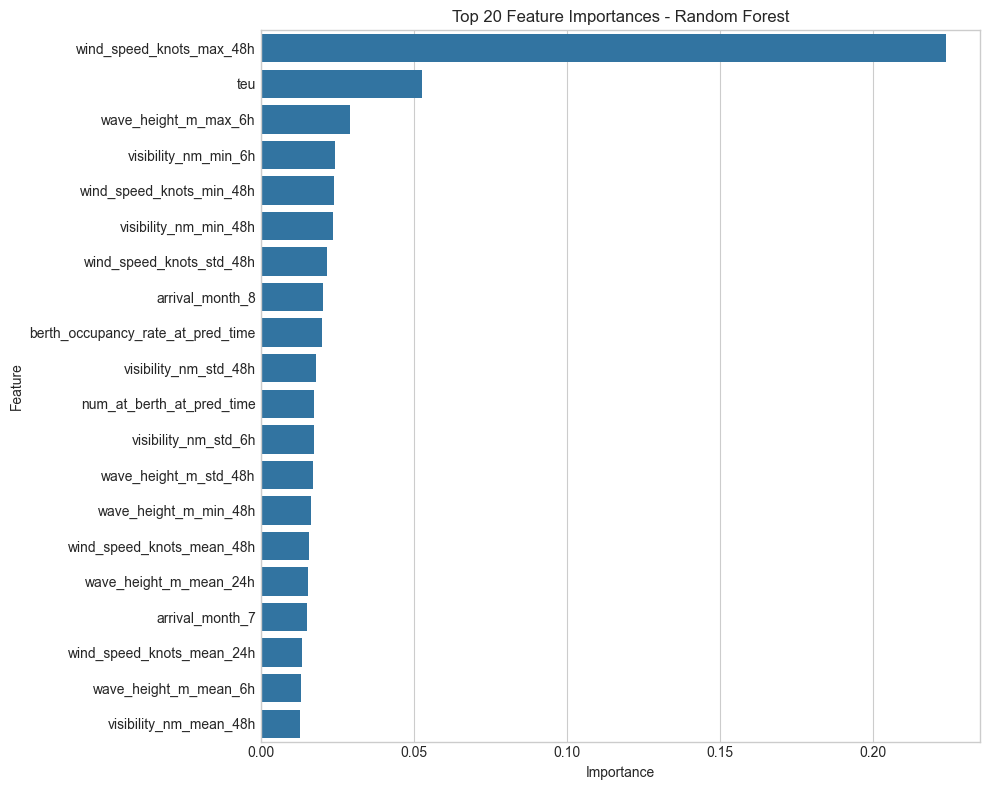


--- Feature Importances for XGBoost Default ---
Saved feature importance plot to XGBoost Default_feature_importance.png


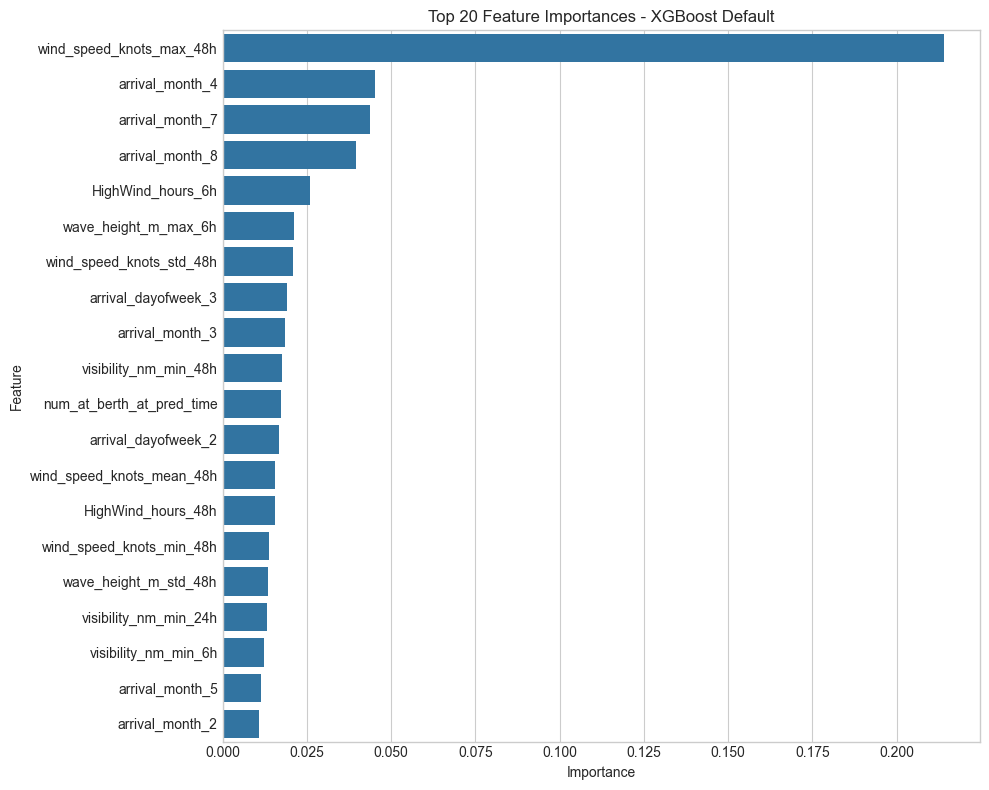


--- Feature Importances for XGBoost Tuned ---
Saved feature importance plot to XGBoost Tuned_feature_importance.png


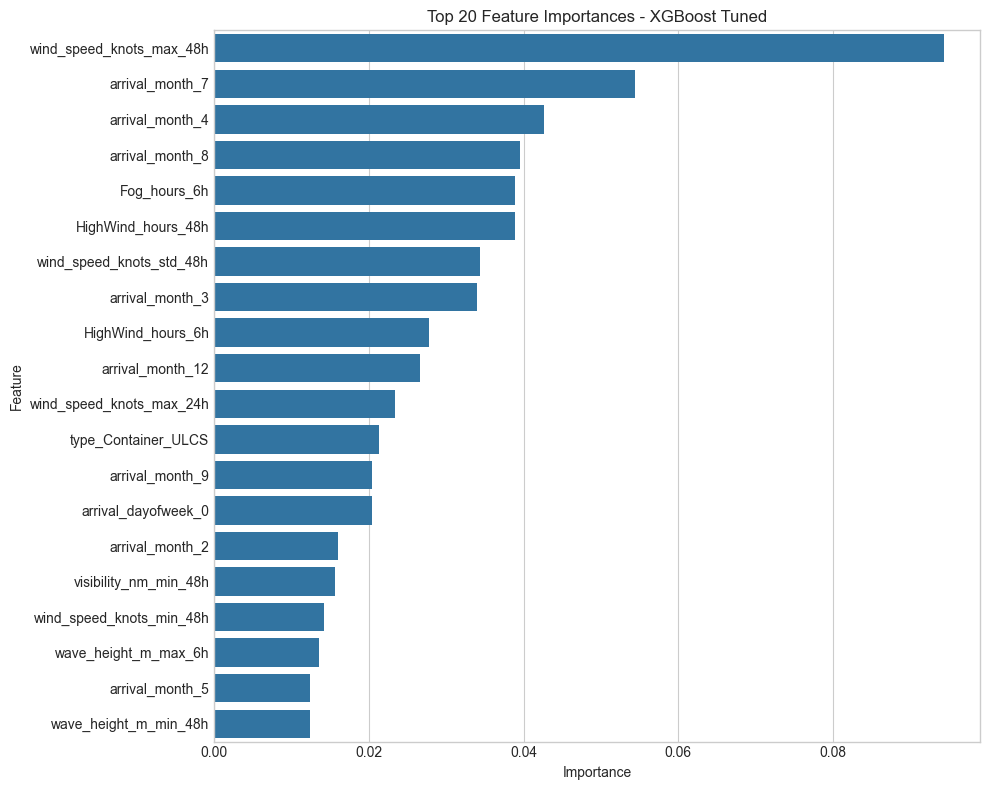

In [31]:
# --- Optional: Feature Importance (for tree-based models) ---
for name in ["Random Forest", "XGBoost Default", "XGBoost Tuned"]:
    if name in trained_pipelines:
        print(f"\n--- Feature Importances for {name} ---")
        try:
            # Need to get feature names after one-hot encoding
            feature_names_raw = numerical_features + list(
                trained_pipelines[name]
                .named_steps["preprocessor"]
                .named_transformers_["cat"]
                .named_steps["onehot"]
                .get_feature_names_out(categorical_features)
            )

            importances = (
                trained_pipelines[name].named_steps["regressor"].feature_importances_
            )

            # Handle cases where number of features doesn't match importances length
            if len(feature_names_raw) != len(importances):
                print(
                    f"Warning: Mismatch between feature names ({len(feature_names_raw)}) and importances ({len(importances)}) for {name}. Skipping plot."
                )
                continue

            feature_importance_df = pd.DataFrame(
                {"Feature": feature_names_raw, "Importance": importances}
            )
            feature_importance_df = feature_importance_df.sort_values(
                by="Importance", ascending=False
            ).head(
                20
            )  # Show top 20

            plt.figure(figsize=(10, 8))
            sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
            plt.title(f"Top 20 Feature Importances - {name}")
            plt.tight_layout()
            # plt.savefig(f"{name}_feature_importance.png") # Save the plot
            print(f"Saved feature importance plot to {name}_feature_importance.png")
            plt.show()  # Uncomment to display plots directly

        except AttributeError:
            print(f"Could not retrieve feature importances for {name}.")
        except Exception as e:
            print(
                f"An error occurred during feature importance plotting for {name}: {e}"
            )

### Error Analysis

In [32]:
def analyze_model_errors(model_name, pipeline, X_test, y_test):
    """
    Performs error analysis on a trained regression pipeline.

    Args:
        pipeline: Fitted scikit-learn pipeline object.
        X_test: Original test features DataFrame (unprocessed).
        y_test: True target values for the test set.
        model_name (str): Name of the model for plot titles.
    """
    print(f"\n--- Error Analysis for {model_name} ---")

    # 1. Get Predictions
    y_pred = pipeline.predict(X_test)
    y_pred = np.maximum(0, y_pred)  # Ensure non-negative delays

    # 2. Calculate Errors (Residuals)
    residuals = y_test - y_pred

    # --- Visualizations ---
    plt.style.use("seaborn-v0_8-whitegrid")  # Use a clean style
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(
        f"Error Analysis: {model_name}", fontsize=16, y=1.02
    )  # Adjust title position

    # 3. Predicted vs. Actual
    ax = axes[0, 0]
    max_val = max(y_test.max(), y_pred.max()) * 1.1
    min_val = (
        min(y_test.min(), y_pred.min()) * 0.9
        if min(y_test.min(), y_pred.min()) < 0
        else 0
    )  # Handle potential negative preds before clipping
    sns.scatterplot(x=y_test, y=y_pred, ax=ax, alpha=0.6)
    ax.plot(
        [min_val, max_val], [min_val, max_val], "r--", lw=2, label="Ideal (y=x)"
    )  # Ideal line
    ax.set_xlabel("Actual Delay (hours)")
    ax.set_ylabel("Predicted Delay (hours)")
    ax.set_title("Predicted vs. Actual Values")
    ax.set_xlim(left=min_val, right=max_val)
    ax.set_ylim(bottom=min_val, top=max_val)
    ax.legend()
    ax.grid(True)

    # 4. Residual Distribution
    ax = axes[0, 1]
    sns.histplot(residuals, kde=True, ax=ax)
    ax.set_xlabel("Residual (Actual - Predicted)")
    ax.set_ylabel("Frequency")
    ax.set_title("Residual Distribution")
    ax.axvline(0, color="r", linestyle="--")  # Line at zero error
    ax.grid(True)

    # 5. Residuals vs. Predicted
    ax = axes[1, 0]
    sns.scatterplot(x=y_pred, y=residuals, ax=ax, alpha=0.6)
    ax.axhline(0, color="r", linestyle="--", lw=2)  # Line at zero error
    ax.set_xlabel("Predicted Delay (hours)")
    ax.set_ylabel("Residual (Actual - Predicted)")
    ax.set_title("Residuals vs. Predicted Values")
    ax.grid(True)

    # 6. Residuals vs. a Key Feature (Example: 'teu')
    ax = axes[1, 1]
    key_feature = "teu"  # Choose an important feature to plot against
    if key_feature in X_test.columns:
        sns.scatterplot(x=X_test[key_feature], y=residuals, ax=ax, alpha=0.6)
        ax.axhline(0, color="r", linestyle="--", lw=2)
        ax.set_xlabel(f"Feature: {key_feature}")
        ax.set_ylabel("Residual (Actual - Predicted)")
        ax.set_title(f"Residuals vs. {key_feature}")
        ax.grid(True)
    else:
        ax.text(
            0.5,
            0.5,
            f"Feature '{key_feature}' not found in X_test.",
            ha="center",
            va="center",
        )
        ax.set_title(f"Residuals vs. {key_feature} (Not Found)")

    plt.tight_layout(
        rect=(0.0, 0.0, 1.0, 0.98)
    )  # Adjust layout to prevent title overlap
    # plt.savefig(f"{model_name.replace(' ', '_').lower()}_error_analysis.png")

    print(
        f"Saved error analysis plot to {model_name.replace(' ', '_').lower()}_error_analysis.png"
    )
    # plt.show() # Uncomment to display plots

    # 7. (Optional) Identify Largest Errors
    error_df = pd.DataFrame(
        {"Actual": y_test, "Predicted": y_pred, "Residual": residuals}
    )
    error_df["Abs_Residual"] = error_df["Residual"].abs()
    largest_errors = error_df.sort_values(by="Abs_Residual", ascending=False).head(10)

    print("\nTop 10 Largest Absolute Errors:")
    print(largest_errors)

    # You could join this back with X_test on index to see the features for the worst predictions
    # print(X_test.loc[largest_errors.index])

#### XGBoost


--- Error Analysis for XGBoost Tuned ---
Saved error analysis plot to xgboost_tuned_error_analysis.png

Top 10 Largest Absolute Errors:
      Actual  Predicted  Residual  Abs_Residual
2254     5.0   0.314796  4.685204      4.685204
1092     5.0   0.754050  4.245950      4.245950
2387     4.0   0.137450  3.862550      3.862550
3153     4.0   0.208072  3.791928      3.791928
4420     4.0   0.414347  3.585653      3.585653
6438     4.0   0.633873  3.366127      3.366127
5272     4.0   0.760422  3.239578      3.239578
4253     3.0   0.266210  2.733790      2.733790
3318     3.0   0.269615  2.730385      2.730385
2836     3.0   0.280965  2.719035      2.719035


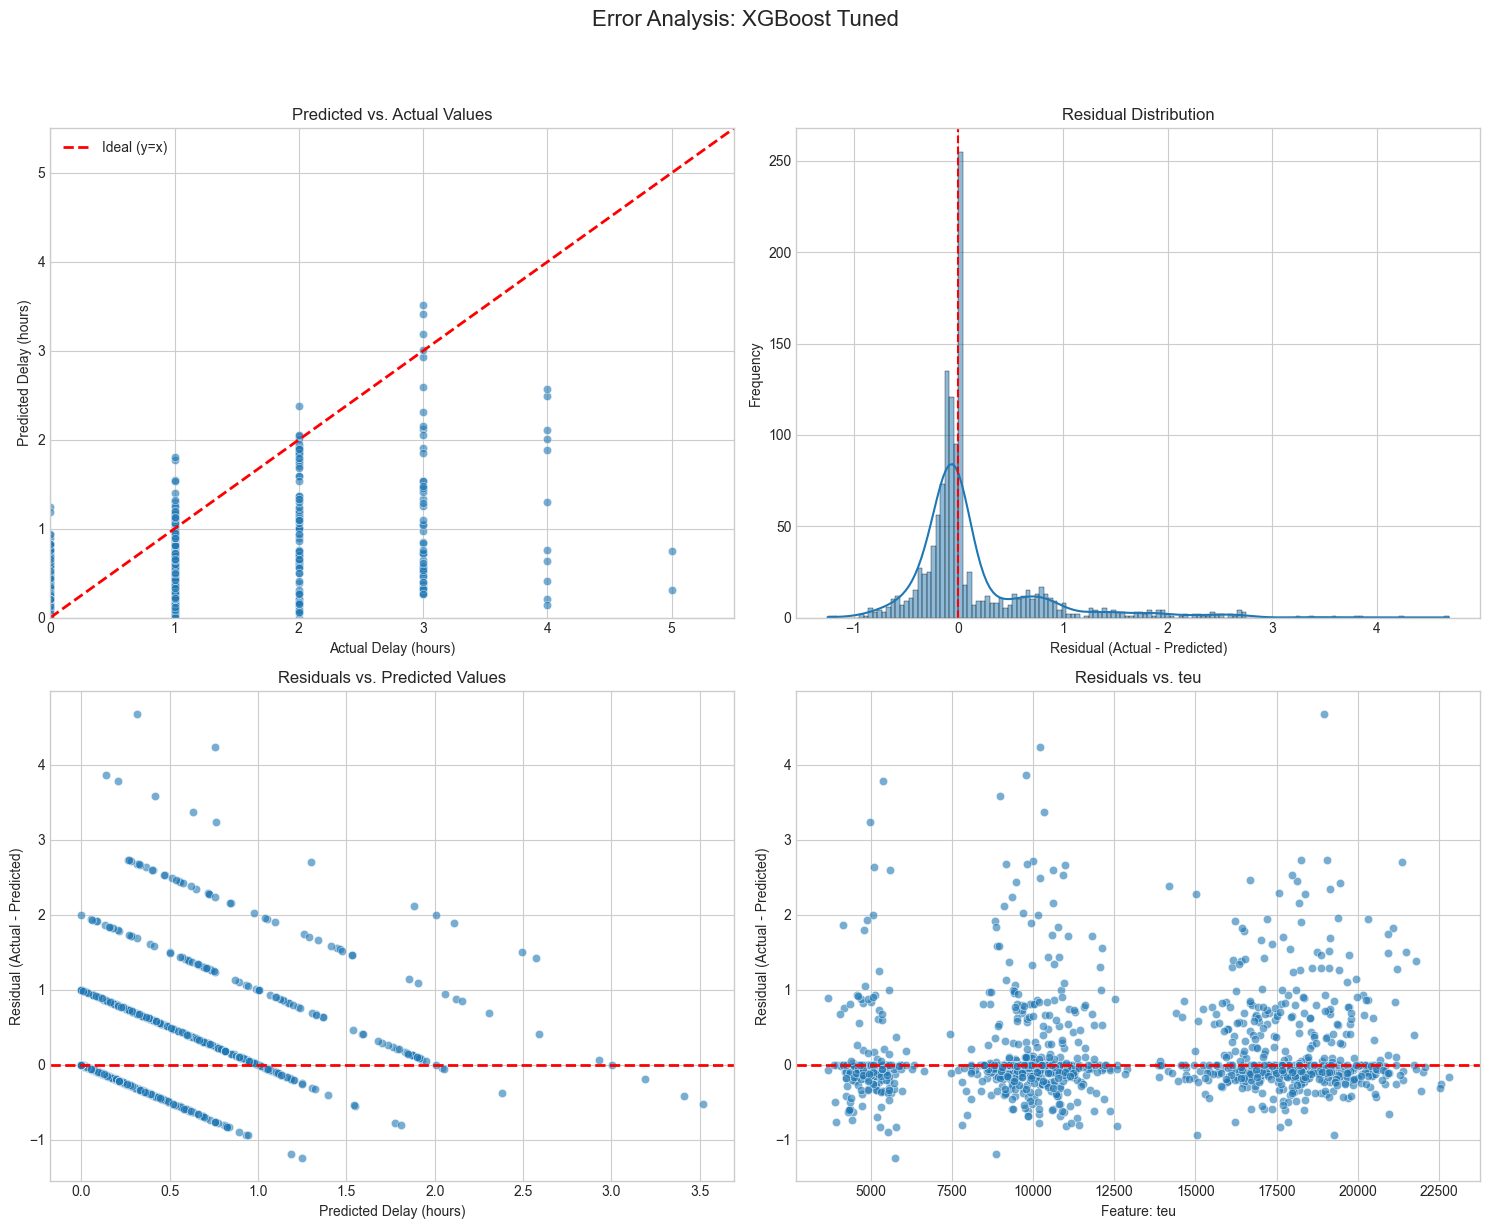

In [33]:
analyze_model_errors(
    "XGBoost Tuned", trained_pipelines["SVR"], X_test, y_test
)

## ARIMA Time Series Analysis

ARIMA (AutoRegressive Integrated Moving Average) is a time series forecasting model that uses past values to predict future values. It combines:
- AR (AutoRegressive): Uses past values in a regression model
- I (Integrated): Differencing to make the time series stationary
- MA (Moving Average): Uses past error terms for forecasting

We'll use ARIMA to forecast weather-related shipping delays based on historical patterns.


--- Preparing Time Series Data for ARIMA ---
Created daily weather delay time series with 358 data points


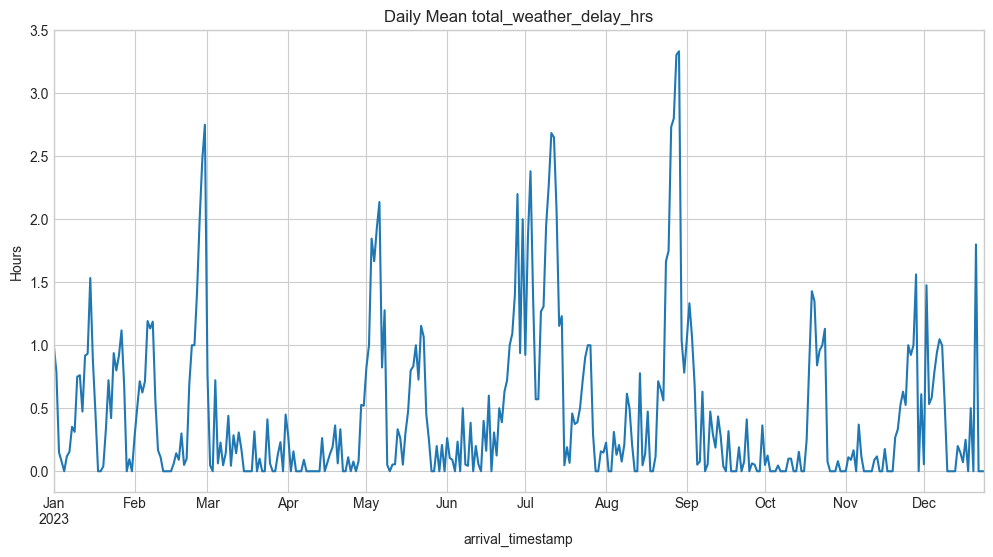

ADF Statistic: -6.072835
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Time series is stationary


In [34]:
# Prepare time series data for ARIMA modeling
print("\n--- Preparing Time Series Data for ARIMA ---")

# 1. Create daily aggregated time series of weather delays
if "arrival_timestamp" not in ops_df.columns:
    base_datetime = pd.to_datetime(SIMULATION_START_DATE)
    ops_df["arrival_timestamp"] = ops_df["arrival_time"].apply(
        lambda h: base_datetime + pd.Timedelta(hours=h)
    )

# Set the timestamp as index for time series analysis
ops_time_series = ops_df.set_index("arrival_timestamp")

# Create a daily aggregated series
daily_delays = ops_time_series[TARGET_COLUMN].resample("D").mean().fillna(0)
print(f"Created daily weather delay time series with {len(daily_delays)} data points")

# Plot the time series
plt.figure(figsize=(12, 6))
daily_delays.plot()
plt.title(f"Daily Mean {TARGET_COLUMN}")
plt.ylabel("Hours")
plt.grid(True)
plt.show()

# Check stationarity with Augmented Dickey-Fuller test
result = adfuller(daily_delays.dropna())
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

# If p-value > 0.05, the time series is not stationary and needs differencing
is_stationary = result[1] < 0.05
if not is_stationary:
    print("Time series is not stationary, differencing is needed")
else:
    print("Time series is stationary")

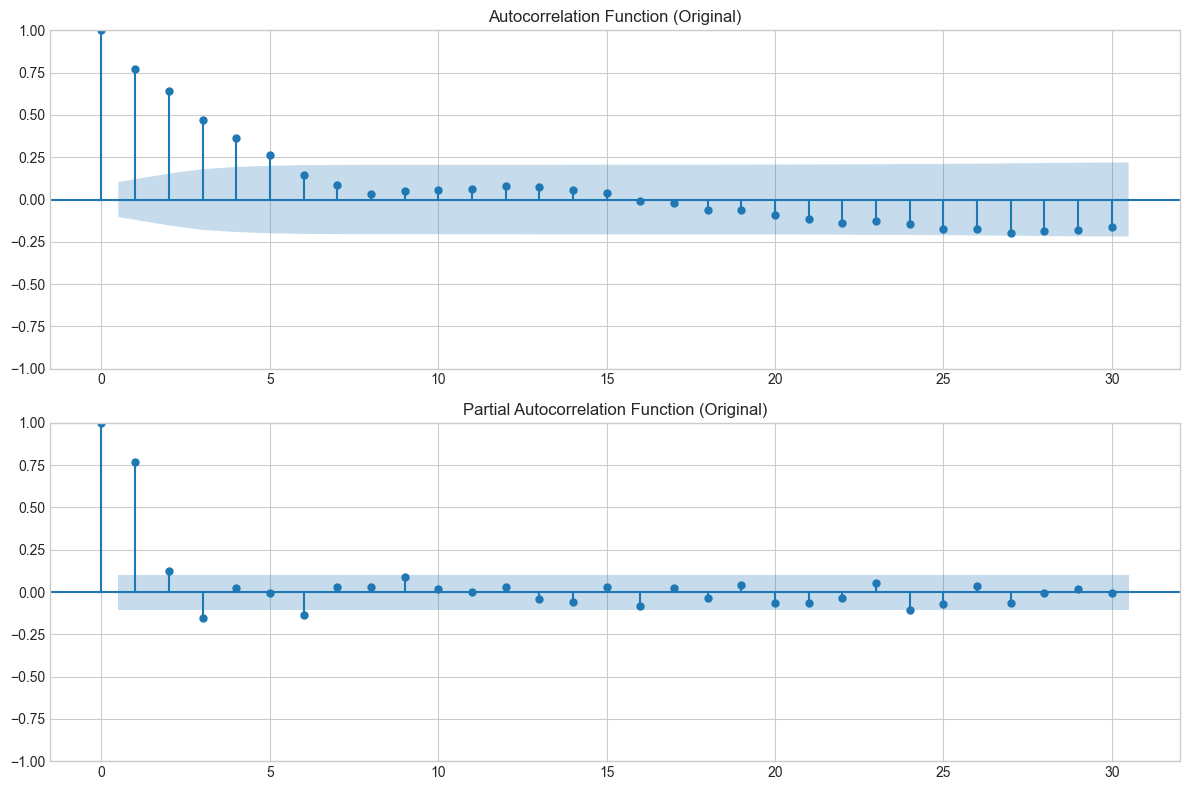


ARIMA Parameter Selection Guide:
- p (AR order): Look for significant spikes in the PACF plot
- d (Differencing): Set to 0 based on stationarity test
- q (MA order): Look for significant spikes in the ACF plot


In [35]:
# ACF and PACF plots for determining ARIMA parameters
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# If not stationary, work with differenced data
diff_order = 0
if not is_stationary:
    diff_order = 1
    diff_series = daily_delays.diff(diff_order).dropna()

    # Recheck stationarity
    diff_result = adfuller(diff_series.dropna())
    print(f"After differencing, ADF Statistic: {diff_result[0]:.6f}")
    print(f"After differencing, p-value: {diff_result[1]:.6f}")

    plot_series = diff_series
    title_suffix = "(Differenced)"
else:
    plot_series = daily_delays
    title_suffix = "(Original)"

# Plot ACF and PACF
plot_acf(plot_series, ax=ax1, lags=30)
ax1.set_title(f"Autocorrelation Function {title_suffix}")

plot_pacf(plot_series, ax=ax2, lags=30)
ax2.set_title(f"Partial Autocorrelation Function {title_suffix}")

plt.tight_layout()
plt.show()

# Guide for parameter selection
print("\nARIMA Parameter Selection Guide:")
print("- p (AR order): Look for significant spikes in the PACF plot")
print("- d (Differencing): Set to", diff_order, "based on stationarity test")
print("- q (MA order): Look for significant spikes in the ACF plot")


--- Fitting ARIMA(1, 0, 1) Model ---
Training data size: 286, Test data size: 72
                                  SARIMAX Results                                  
Dep. Variable:     total_weather_delay_hrs   No. Observations:                  286
Model:                      ARIMA(1, 0, 1)   Log Likelihood                -131.692
Date:                     Sun, 27 Apr 2025   AIC                            271.384
Time:                             20:59:50   BIC                            286.008
Sample:                         01-01-2023   HQIC                           277.246
                              - 10-13-2023                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4895      0.164      2.980      0.003       0.167       0.811
ar.L1    

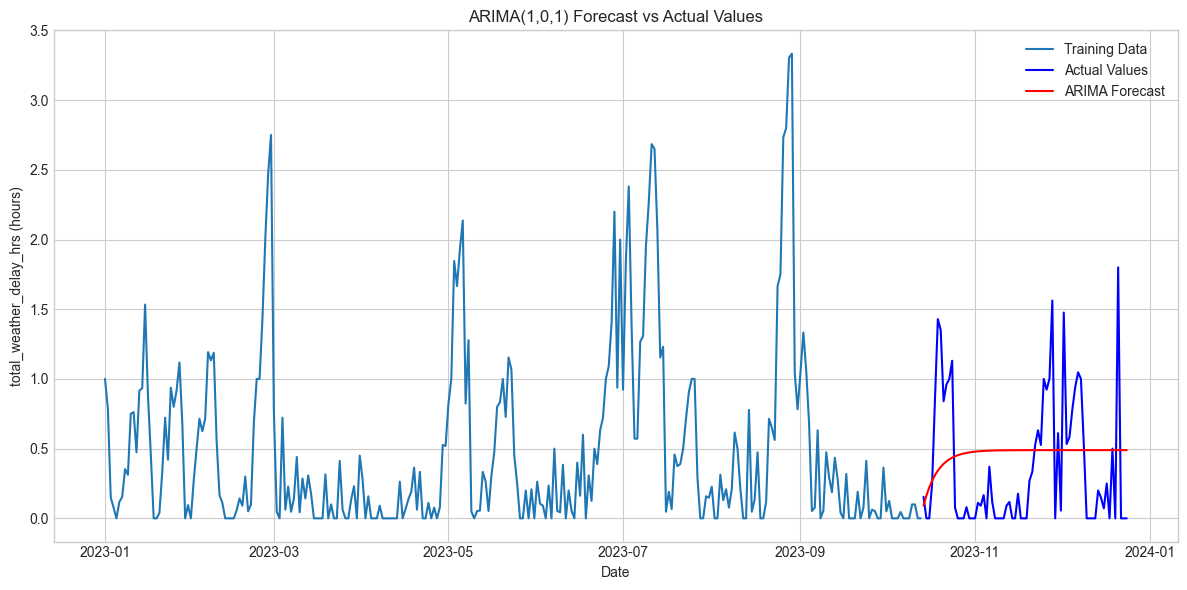

In [36]:
# Fit ARIMA model
# Based on ACF/PACF plots, choose appropriate p, d, q values
# Starting with standard values and can be adjusted
p = 1  # AR order
d = diff_order  # Differencing order (from stationarity test)
q = 1  # MA order

print(f"\n--- Fitting ARIMA({p}, {d}, {q}) Model ---")

# Split data for training and testing
train_size = int(len(daily_delays) * 0.8)
train_data = daily_delays[:train_size]
test_data = daily_delays[train_size:]
print(f"Training data size: {len(train_data)}, Test data size: {len(test_data)}")

try:
    start_train_time = time.time()
    # Fit the model
    model = ARIMA(train_data, order=(p, d, q))
    model_fit = model.fit()
    print(model_fit.summary())

    # Save the model
    os.makedirs("models", exist_ok=True)
    model_fit.save("models/arima_model.pkl")
    print("ARIMA model saved to models/arima_model.pkl")

    # Make forecasts
    forecast_steps = len(test_data)
    forecast = model_fit.forecast(steps=forecast_steps)

    # Ensure forecasts are non-negative
    forecast = np.maximum(0, forecast)

    # Evaluate forecast
    mse = mean_squared_error(test_data, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, forecast)

    end_train_time = time.time()
    duration = end_train_time - start_train_time
    print(f"ARIMA model training and evaluation took {duration:.2f} seconds.")
    print(f"\nARIMA Forecast Evaluation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Add ARIMA results to the comparison table
    results["ARIMA"] = {
        "RMSE": rmse,
        "MAE": mae,
        "R2": None,  # R² not typically used for time series
        "Training Time (s)": duration,
    }

    # Plot forecast vs actual values
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label="Training Data")
    plt.plot(test_data.index, test_data, color="blue", label="Actual Values")
    plt.plot(test_data.index, forecast, color="red", label="ARIMA Forecast")
    plt.title(f"ARIMA({p},{d},{q}) Forecast vs Actual Values")
    plt.xlabel("Date")
    plt.ylabel(f"{TARGET_COLUMN} (hours)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error fitting ARIMA model: {e}")

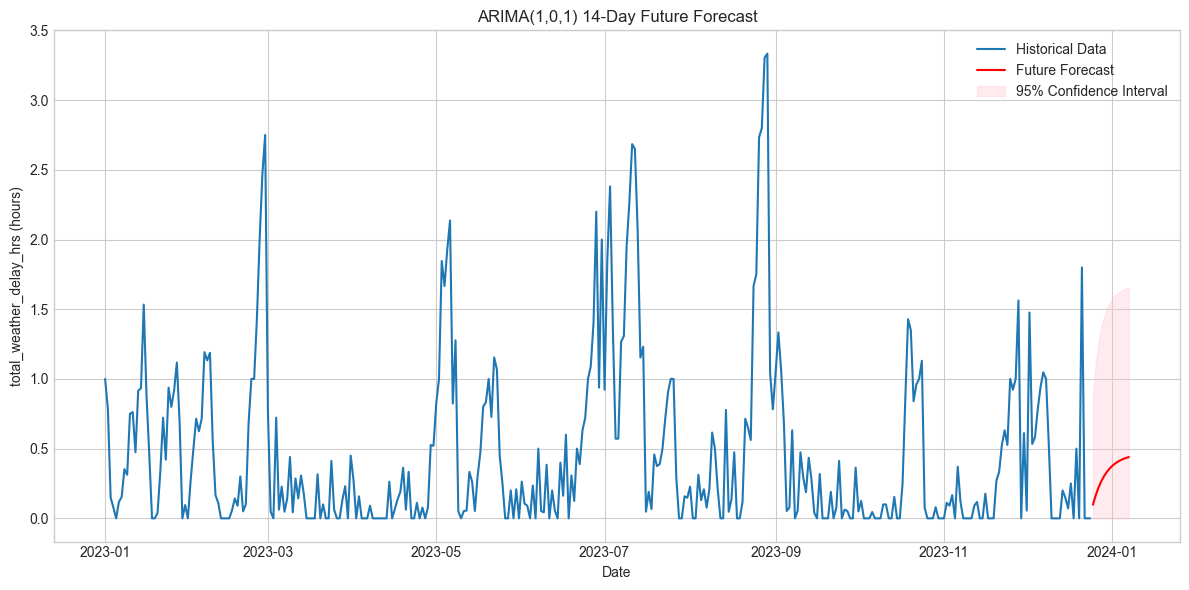


Future Forecast Values:
2023-12-25: 0.10 hours
2023-12-26: 0.17 hours
2023-12-27: 0.22 hours
2023-12-28: 0.27 hours
2023-12-29: 0.30 hours
2023-12-30: 0.33 hours
2023-12-31: 0.36 hours
2024-01-01: 0.38 hours
2024-01-02: 0.39 hours
2024-01-03: 0.41 hours
2024-01-04: 0.42 hours
2024-01-05: 0.43 hours
2024-01-06: 0.43 hours
2024-01-07: 0.44 hours


In [37]:
# Make future forecasts
forecast_days = 14  # Forecast for 14 days ahead

try:
    # Retrain on full dataset
    full_model = ARIMA(daily_delays, order=(p, d, q))
    full_model_fit = full_model.fit()

    # Make future forecasts
    future_forecast = full_model_fit.forecast(steps=forecast_days)

    # Ensure forecasts are non-negative
    future_forecast = np.maximum(0, future_forecast)

    # Create forecast index
    last_date = daily_delays.index[-1]
    forecast_index = pd.date_range(
        start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq="D"
    )
    future_forecast = pd.Series(future_forecast, index=forecast_index)

    # Plot historical data and future forecast
    plt.figure(figsize=(12, 6))
    plt.plot(daily_delays.index, daily_delays, label="Historical Data")
    plt.plot(
        future_forecast.index, future_forecast, color="red", label="Future Forecast"
    )

    # Add confidence intervals if available
    try:
        forecast_obj = full_model_fit.get_forecast(steps=forecast_days)
        conf_int = forecast_obj.conf_int()
        conf_int.index = forecast_index
        plt.fill_between(
            conf_int.index,
            np.maximum(0, conf_int.iloc[:, 0]),
            conf_int.iloc[:, 1],
            color="pink",
            alpha=0.3,
            label="95% Confidence Interval",
        )
    except:
        print("Confidence intervals not available for this model")

    plt.title(f"ARIMA({p},{d},{q}) {forecast_days}-Day Future Forecast")
    plt.xlabel("Date")
    plt.ylabel(f"{TARGET_COLUMN} (hours)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print future forecast values
    print("\nFuture Forecast Values:")
    for date, value in future_forecast.items():
        print(f"{date.date()}: {value:.2f} hours")

except Exception as e:
    print(f"Error making future forecast: {e}")

In [38]:
# Try Seasonal ARIMA if we have enough data
if len(daily_delays) >= 365:  # At least a year of data for seasonal patterns
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    print("\n--- Fitting Seasonal ARIMA Model ---")

    # SARIMA parameters
    # (p,d,q) × (P,D,Q)s where s is the seasonal period
    p, d, q = 1, diff_order, 1  # Non-seasonal components (from ARIMA)
    P, D, Q = 1, 1, 1  # Seasonal components
    s = 7  # Weekly seasonality

    try:
        # Train-test split
        train_data = daily_delays[:train_size]
        test_data = daily_delays[train_size:]

        # Fit the model
        sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
        sarima_fit = sarima_model.fit(disp=False)
        print(sarima_fit.summary())

        # Save the model
        sarima_fit.save("models/sarima_model.pkl")
        print("SARIMA model saved to models/sarima_model.pkl")

        # Make forecasts
        forecast_steps = len(test_data)
        sarima_forecast = sarima_fit.forecast(steps=forecast_steps)
        sarima_forecast = np.maximum(0, sarima_forecast)  # Non-negative

        # Evaluate forecast
        mse = mean_squared_error(test_data, sarima_forecast)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test_data, sarima_forecast)

        print(f"\nSARIMA Forecast Evaluation:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")

        # Add SARIMA results to comparison
        results["SARIMA"] = {
            "RMSE": rmse,
            "MAE": mae,
            "R2": None,
            "Training Time (s)": None,
        }

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(train_data.index, train_data, label="Training Data")
        plt.plot(test_data.index, test_data, color="blue", label="Actual Values")
        plt.plot(
            test_data.index, sarima_forecast, color="green", label="SARIMA Forecast"
        )
        plt.title(f"SARIMA({p},{d},{q})X({P},{D},{Q}){s} Forecast vs Actual Values")
        plt.xlabel("Date")
        plt.ylabel(f"{TARGET_COLUMN} (hours)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error fitting SARIMA model: {e}")
else:
    print(
        "\nNot enough data for seasonal modeling. Need at least 365 data points for reliable seasonal patterns."
    )


Not enough data for seasonal modeling. Need at least 365 data points for reliable seasonal patterns.


In [39]:
# Updated Model Comparison including ARIMA
print("\n--- Updated Model Comparison Including Time Series Models ---")
updated_results_df = pd.DataFrame(results).T  # Transpose for better readability
updated_results_df = updated_results_df.sort_values(
    by="RMSE", ascending=True, na_position="last"  # Sort by RMSE (lower is better)
)
print(updated_results_df)


--- Updated Model Comparison Including Time Series Models ---
                       RMSE       MAE        R2  Training Time (s)
XGBoost Tuned      0.487868  0.257054  0.683612           2.461022
ARIMA              0.490304  0.424943       NaN           0.108550
XGBoost Default    0.509340  0.279572  0.655149           0.578951
Random Forest      0.519543  0.303434  0.641194           3.445663
SVR                0.657859  0.350281  0.424716           2.026826
Linear Regression  0.738787  0.495902  0.274471           0.085880


## MLP

In [40]:
# --- Define the Updated MLP Training Function ---

def train_evaluate_mlp(X_train, y_train, X_test, y_test, preprocessor, epochs=100, batch_size=32, model_name="MLP"):
    """
    Trains, evaluates, saves, and returns an MLP model using TensorFlow/Keras.

    Args:
        X_train, y_train: Training data and target.
        X_test, y_test: Testing data and target.
        preprocessor: The *fitted* scikit-learn ColumnTransformer.
        epochs (int): Maximum number of training epochs.
        batch_size (int): Batch size for training.
        model_name (str): Name for saving the model.

    Returns:
        tuple: (trained_keras_model, results_dict)
               - trained_keras_model: The best Keras model object loaded from checkpoint.
               - results_dict: Dictionary containing evaluation metrics (RMSE, MAE, R2, Training Time).
               Returns (None, results_dict with NaNs) on error.
    """
    print(f"\n--- Setting up and Training {model_name} ---")
    start_train_time = time.time()
    best_mlp_model = None # Initialize to None

    # 1. Preprocess the data using the *fitted* preprocessor
    print("Preprocessing data for MLP...")
    try:
        X_train_processed = preprocessor.transform(X_train)
        X_test_processed = preprocessor.transform(X_test)
        # Keras prefers dense numpy arrays
        if hasattr(X_train_processed, "toarray"): # Check if sparse
             X_train_processed = X_train_processed.toarray()
             X_test_processed = X_test_processed.toarray()
        print(f"Input shape after preprocessing: {X_train_processed.shape}")
    except Exception as e:
        print(f"Error during preprocessing: {e}")
        # Return None for model and NaN results on error
        results = {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan, 'Training Time (s)': 0}
        return None, results

    # 2. Define the MLP Architecture
    input_dim = X_train_processed.shape[1]
    mlp_model = keras.Sequential(
        [
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation="relu", name="hidden1"),
            layers.Dropout(0.3),
            layers.Dense(64, activation="relu", name="hidden2"),
            layers.Dropout(0.3),
            layers.Dense(32, activation="relu", name="hidden3"),
            layers.Dense(1, activation="linear", name="output")
        ],
        name=model_name,
    )
    mlp_model.summary()

    # 3. Compile the Model
    learning_rate = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    mlp_model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae']
    )

    # 4. Set up Callbacks
    os.makedirs('models_keras', exist_ok=True)
    clean_model_name = model_name.replace(' ', '_').replace('/', '_').lower()
    model_checkpoint_path = f"models_keras/{clean_model_name}_best.keras"

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True # Important: restores best weights automatically
    )
    model_checkpoint = ModelCheckpoint(
        filepath=model_checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, # Save entire model in .keras format
        verbose=0
    )

    # 5. Train the Model
    print(f"Training MLP for max {epochs} epochs (Batch Size: {batch_size})...")
    history = mlp_model.fit(
        X_train_processed,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_processed, y_test),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # 6. Load the Best Model (Even with restore_best_weights, loading ensures we have the standalone best model object)
    # The ModelCheckpoint callback already saved the best *entire* model.
    print(f"Loading best model saved to {model_checkpoint_path}...")
    try:
        # Use the model object directly if restore_best_weights=True was effective,
        # or load from the saved file as a fallback or for verification.
        # Loading from file is safer if you want to be sure you have the saved version.
        best_mlp_model = keras.models.load_model(model_checkpoint_path)
        print("Successfully loaded best model from file.")
    except Exception as e:
        print(f"Warning: Could not load best model from checkpoint file ({e}). Using the model state after training (which should have restored best weights).")
        # If loading fails, the mlp_model object itself should have the best weights due to restore_best_weights=True
        best_mlp_model = mlp_model


    # 7. Evaluate the Best Model on the Test Set
    print("Evaluating MLP on test set...")
    # Ensure we use the best model for prediction
    if best_mlp_model is not None:
        y_pred = best_mlp_model.predict(X_test_processed).flatten()
        y_pred = np.maximum(0, y_pred) # Ensure non-negative

        final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        final_mae = mean_absolute_error(y_test, y_pred)
        final_r2 = r2_score(y_test, y_pred)
        print(f"Test Set RMSE: {final_rmse:.4f}")
        print(f"Test Set MAE: {final_mae:.4f}")
        print(f"Test Set R2 Score: {final_r2:.4f}")
    else:
        print("Evaluation skipped as best model could not be obtained.")
        final_rmse, final_mae, final_r2 = np.nan, np.nan, np.nan


    end_train_time = time.time()
    duration = end_train_time - start_train_time
    print(f"Total Training/Evaluation Time: {duration:.2f} seconds")

    results = {'RMSE': final_rmse, 'MAE': final_mae, 'R2': final_r2, 'Training Time (s)': duration}

    # Return the trained model object and the results
    return best_mlp_model, results

# --- How to Call the Updated Function ---

# Assuming 'fitted_preprocessor' is defined correctly
# trained_mlp_model = None # Initialize
# mlp_results = None

# if 'fitted_preprocessor' in locals(): # Check if preprocessor was obtained
#      trained_mlp_model, mlp_results = train_evaluate_mlp(
#          X_train, y_train, X_test, y_test, fitted_preprocessor
#      )
#
#      # --- Append results to your overall comparison ---
#      if 'final_results' in locals() and mlp_results['RMSE'] is not np.nan:
#          final_results['MLP'] = mlp_results
#          print("\n--- Final Model Comparison (including MLP) ---")
#          results_df = pd.DataFrame(final_results).T
#          results_df = results_df.sort_values(by='RMSE', ascending=True)
#          print(results_df)
#      else:
#          print("Could not add MLP results to comparison.")
#
#      # You can now use 'trained_mlp_model' if needed, e.g., for further analysis or prediction
#      # if trained_mlp_model:
#      #    print("\nMLP model object returned successfully.")
#
# else:
#     print("MLP training skipped because fitted preprocessor was not available.")

In [41]:
# Make sure 'trained_pipelines' dictionary exists from previous training
if "XGBoost Tuned" in trained_pipelines: # Or use another reliable pipeline like RandomForest
    fitted_preprocessor = trained_pipelines['XGBoost Tuned'].named_steps['preprocessor']
    print("Extracted fitted preprocessor from XGBoost Tuned pipeline.")
else:
    print("Error: Cannot find a fitted pipeline to extract the preprocessor from.")


Extracted fitted preprocessor from XGBoost Tuned pipeline.


In [42]:
if 'fitted_preprocessor' in locals(): # Check if preprocessor was obtained
     trained_mlp_model, results['MLP'] = train_evaluate_mlp(
         X_train, y_train, X_test, y_test, fitted_preprocessor
     )

     # You can now use 'trained_mlp_model' if needed, e.g., for further analysis or prediction
     if trained_mlp_model:
        print("\nMLP model object returned successfully.")

else:
    print("MLP training skipped because fitted preprocessor was not available.")



--- Setting up and Training MLP ---
Preprocessing data for MLP...
Input shape after preprocessing: (5157, 107)


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 128)            │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,193 (94.50 KB)

 Trainable params: 24,193 (94.50 KB)

 Non-trainable params: 0 (0.00 B)

Training MLP for max 100 epochs (Batch Size: 32)...
Epoch 1/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8176 - mae: 0.6174 - rmse: 0.9013 - val_loss: 0.5983 - val_mae: 0.5043 - val_rmse: 0.7735
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5800 - mae: 0.5134 - rmse: 0.7613 - val_loss: 0.5320 - val_mae: 0.4906 - val_rmse: 0.7294
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5395 - mae: 0.5069 - rmse: 0.7339 - val_loss: 0.5158 - val_mae: 0.4690 - val_rmse: 0.7182
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5315 - mae: 0.5068 - rmse: 0.7286 - val_loss: 0.5406 - val_mae: 0.4374 - val_rmse: 0.7352
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4678 - mae: 0.4505 - rmse: 0.6836 - val_loss: 0.4712 - val_mae: 0.4429 - val_rmse: 0.6864
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4612 - mae: 0.4537 - rmse: 0.6774 - val_loss: 0.4465 - val_mae: 0.4249 - val_rmse: 0.6682
Epoch 7/100
162/162 ━━━━━━━━━━

In [43]:
print("\n--- Model Comparison (including MLP) ---")
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='RMSE', ascending=True)
print(results_df)


--- Model Comparison (including MLP) ---
                       RMSE       MAE        R2  Training Time (s)
XGBoost Tuned      0.487868  0.257054  0.683612           2.461022
ARIMA              0.490304  0.424943       NaN           0.108550
XGBoost Default    0.509340  0.279572  0.655149           0.578951
Random Forest      0.519543  0.303434  0.641194           3.445663
MLP                0.600686  0.351780  0.520364          24.210209
SVR                0.657859  0.350281  0.424716           2.026826
Linear Regression  0.738787  0.495902  0.274471           0.085880


## RNN and CNN

1.	Input Shape: These models excel at processing sequences. The most natural sequence in our data is the hourly weather forecast. Therefore, we need to reshape the input data specifically for these models. We'll treat the hourly weather forecast as the sequence and combine it with the other "static" features (vessel type, TEU, time features, port state features).
2.	Data Preparation: We'll need a separate data preparation step to create:
    - A 3D array for the weather sequence: (n_samples, sequence_length, n_weather_features)
    - A 2D array for the static features: (n_samples, n_static_features)
3.	Model Architecture: We'll use the Keras Functional API to build models with two distinct input branches (one for the sequence, one for static features) that are later merged.
4.	Preprocessing: Both the sequence data and the static data need appropriate scaling/encoding. This should ideally be done after the train/test split.



### Sequence Data

In [44]:
def prepare_sequence_data(model_data, weather_df, target_column,
                          static_num_features, static_cat_features,
                          weather_seq_vars, seq_length_hours, base_datetime):
    """
    Prepares data specifically for RNN/CNN models with sequence and static inputs.
    Handles train/test split internally for correct scaler fitting.

    Args:
        model_data (pd.DataFrame): DataFrame containing vessel ops, static features,
                                            arrival_timestamp, and target column.
        weather_df (pd.DataFrame): DataFrame with hourly weather data, DatetimeIndex.
        target_column (str): Name of the target variable column.
        static_num_features (list): List of names of numerical static features.
        static_cat_features (list): List of names of categorical static features.
        weather_seq_vars (list): List of weather variable names to include in the sequence.
        seq_length_hours (int): Length of the weather sequence forecast (e.g., 48).
        base_datetime (pd.Timestamp): Simulation start datetime for time conversion.

    Returns:
        tuple: (X_train_seq, X_train_static_proc,
                X_test_seq, X_test_static_proc,
                y_train, y_test,
                static_preprocessor, seq_scaler) # Return fitted processors
    """
    print(f"\n--- Preparing Data for Sequence Models (Seq Length: {seq_length_hours} hrs) ---")

    # Make a copy to avoid modifying original df
    data_full = model_data.copy()

    # --- Feature Extraction for Sequence ---
    sequences = []
    valid_indices = [] # Keep track of rows where sequence extraction is successful
    
    print(f"Extracting {seq_length_hours}hr weather sequences...")
    start_seq_time = time.time()
    if not weather_df.index.is_monotonic_increasing:
        weather_df = weather_df.sort_index()

    for idx, row in data_full.iterrows():
        arrival_ts = row['arrival_timestamp']
        # Use the floor of the arrival hour as the start of the sequence window
        forecast_start_time = arrival_ts.floor('h')
        forecast_end_time = forecast_start_time + pd.Timedelta(hours=seq_length_hours - 1) # Inclusive end

        # Extract weather sequence
        seq_data = weather_df.loc[forecast_start_time : forecast_end_time, weather_seq_vars]

        if len(seq_data) == seq_length_hours:
            sequences.append(seq_data.values) # Append numpy array
            valid_indices.append(idx)
        else: # Optional: print warning if sequence is too short
            print(f"Warning: Insufficient weather data for index {idx}, arrival {arrival_ts}. Found {len(seq_data)}/{seq_length_hours} hours.")


    print(f"Sequence extraction took {time.time() - start_seq_time:.2f} seconds.")

    if not valid_indices:
        print("Error: No valid sequences could be extracted. Check weather data range and sequence length.")
        return None, None, None, None, None, None, None, None, None

    # Filter the main dataframe and create the sequence array
    data_filtered = data_full.loc[valid_indices].reset_index(drop=True)
    X_seq_all = np.array(sequences)
    y_all = data_filtered[target_column].values

    print(f"Filtered data size: {len(data_filtered)}. Sequence array shape: {X_seq_all.shape}")

    # --- Prepare Static Features ---
    X_static_all = data_filtered[static_cat_features + static_num_features]

    # --- Train/Test Split (Crucial BEFORE fitting scalers/encoders) ---
    indices = np.arange(len(data_filtered))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

    X_train_seq, X_test_seq = X_seq_all[train_idx], X_seq_all[test_idx]
    X_train_static_raw, X_test_static_raw = X_static_all.iloc[train_idx], X_static_all.iloc[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    # --- Preprocessing Static Features ---
    print("Preprocessing static features...")
    static_numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    static_categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

    static_preprocessor = ColumnTransformer(
        transformers=[
            ('num', static_numeric_transformer, static_num_features),
            ('cat', static_categorical_transformer, static_cat_features)],
        remainder='passthrough' # Keep other columns if any, though ideally only specified ones are used
    )

    # Fit on training data ONLY
    X_train_static_proc = static_preprocessor.fit_transform(X_train_static_raw)
    # Transform test data
    X_test_static_proc = static_preprocessor.transform(X_test_static_raw)
    if hasattr(X_train_static_proc, "toarray"): # Convert if sparse
        X_train_static_proc = X_train_static_proc.toarray()
        X_test_static_proc = X_test_static_proc.toarray()

    # --- Preprocessing Sequence Features ---
    # Scale each weather feature across all samples and time steps
    # Reshape sequence data to 2D for scaler: (n_samples * seq_length, n_features)
    print("Preprocessing sequence features...")
    n_samples_train, seq_len, n_features_seq = X_train_seq.shape
    X_train_seq_reshaped = X_train_seq.reshape(-1, n_features_seq)

    seq_scaler = StandardScaler()
    # Fit scaler on TRAINING data only
    seq_scaler.fit(X_train_seq_reshaped)

    # Transform train data and reshape back to 3D
    X_train_seq_scaled_reshaped = seq_scaler.transform(X_train_seq_reshaped)
    X_train_seq = X_train_seq_scaled_reshaped.reshape(n_samples_train, seq_len, n_features_seq)

    # Transform test data and reshape back to 3D
    n_samples_test = X_test_seq.shape[0]
    X_test_seq_reshaped = X_test_seq.reshape(-1, n_features_seq)
    X_test_seq_scaled_reshaped = seq_scaler.transform(X_test_seq_reshaped)
    X_test_seq = X_test_seq_scaled_reshaped.reshape(n_samples_test, seq_len, n_features_seq)

    print("Sequence data preparation complete.")
    print(f"X_train_seq shape: {X_train_seq.shape}, X_train_static_proc shape: {X_train_static_proc.shape}")
    print(f"X_test_seq shape: {X_test_seq.shape}, X_test_static_proc shape: {X_test_static_proc.shape}")


    return (X_train_seq, X_train_static_proc,
            X_test_seq, X_test_static_proc,
            y_train, y_test,
            static_preprocessor, seq_scaler,
            data_filtered.index[test_idx]) # Return fitted processors for potential saving/reuse

### RNN (LSTM) Training Function

In [45]:
def train_evaluate_rnn(X_train_seq, X_train_static, y_train,
                         X_test_seq, X_test_static, y_test,
                         epochs=50, batch_size=32, model_name="RNN_LSTM"):
    """
    Trains, evaluates, saves, and returns an RNN (LSTM) model.

    Args:
        X_train_seq, X_train_static: Processed training data (sequence and static).
        y_train: Training target.
        X_test_seq, X_test_static: Processed testing data.
        y_test: Testing target.
        epochs, batch_size: Training parameters.
        model_name: Name for saving.

    Returns:
        tuple: (trained_keras_model, results_dict)
    """
    print(f"\n--- Setting up and Training {model_name} ---")
    start_train_time = time.time()
    best_rnn_model = None

    # --- Define Model Architecture (Functional API) ---
    # Input Layers
    sequence_input = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]), name="weather_sequence_input")
    static_input = Input(shape=(X_train_static.shape[1],), name="static_features_input")

    # Branch 1: Process Sequence with LSTM
    lstm_out = LSTM(64, name="lstm_layer")(sequence_input) # Output shape: (batch, 64)
    lstm_out = Dropout(0.3, name="lstm_dropout")(lstm_out)

    # Branch 2: Process Static Features (Optional: add Dense layer)
    # static_dense = Dense(32, activation='relu', name="static_dense")(static_input)

    # Concatenate the outputs
    # combined = concatenate([lstm_out, static_dense], name="concatenate")
    combined = concatenate([lstm_out, static_input], name="concatenate") # Simpler: combine directly

    # Final Dense Layers for Regression
    dense1 = Dense(64, activation="relu", name="combined_dense1")(combined)
    dropout1 = Dropout(0.3, name="combined_dropout1")(dense1)
    dense2 = Dense(32, activation="relu", name="combined_dense2")(dropout1)
    output = Dense(1, activation="linear", name="output")(dense2)

    # Create the Model
    rnn_model = Model(inputs=[sequence_input, static_input], outputs=output, name=model_name)
    rnn_model.summary()

    # --- Compile ---
    learning_rate = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    rnn_model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])

    # --- Callbacks ---
    os.makedirs('models_keras', exist_ok=True)
    clean_model_name = model_name.replace(' ', '_').replace('/', '_').lower()
    model_checkpoint_path = f"models_keras/{clean_model_name}_best.keras"
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(filepath=model_checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False)

    # --- Train ---
    # NOTE: Input data must be a list or tuple matching the input layers
    print(f"Training {model_name}...")
    history = rnn_model.fit(
        [X_train_seq, X_train_static], # Pass inputs as a list
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_test_seq, X_test_static], y_test), # Validation data also as list
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # --- Load Best Model ---
    print(f"Loading best {model_name} saved to {model_checkpoint_path}...")
    try:
        best_rnn_model = keras.models.load_model(model_checkpoint_path)
        print("Successfully loaded best model from file.")
    except Exception as e:
        print(f"Warning: Could not load best model from checkpoint file ({e}). Using model state after training.")
        best_rnn_model = rnn_model

    # --- Evaluate ---
    print(f"Evaluating {model_name} on test set...")
    if best_rnn_model is not None:
        y_pred = best_rnn_model.predict([X_test_seq, X_test_static]).flatten()
        y_pred = np.maximum(0, y_pred)
        final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        final_mae = mean_absolute_error(y_test, y_pred)
        final_r2 = r2_score(y_test, y_pred)
        print(f"Test Set RMSE: {final_rmse:.4f}")
        print(f"Test Set MAE: {final_mae:.4f}")
        print(f"Test Set R2 Score: {final_r2:.4f}")
    else:
        print("Evaluation skipped.")
        final_rmse, final_mae, final_r2 = np.nan, np.nan, np.nan

    end_train_time = time.time()
    duration = end_train_time - start_train_time
    results = {'RMSE': final_rmse, 'MAE': final_mae, 'R2': final_r2, 'Training Time (s)': duration}
    return best_rnn_model, results

### CNN (1D) Training Function

In [46]:
def train_evaluate_cnn(X_train_seq, X_train_static, y_train,
                         X_test_seq, X_test_static, y_test,
                         epochs=50, batch_size=32, model_name="CNN_1D"):
    """
    Trains, evaluates, saves, and returns a 1D CNN model.

    Args:
        X_train_seq, X_train_static: Processed training data (sequence and static).
        y_train: Training target.
        X_test_seq, X_test_static: Processed testing data.
        y_test: Testing target.
        epochs, batch_size: Training parameters.
        model_name: Name for saving.

    Returns:
        tuple: (trained_keras_model, results_dict)
    """
    print(f"\n--- Setting up and Training {model_name} ---")
    start_train_time = time.time()
    best_cnn_model = None

    # --- Define Model Architecture (Functional API) ---
    sequence_input = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]), name="weather_sequence_input")
    static_input = Input(shape=(X_train_static.shape[1],), name="static_features_input")

    # Branch 1: Process Sequence with 1D CNN
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name="conv1")(sequence_input)
    pool1 = MaxPooling1D(pool_size=2, name="pool1")(conv1)
    conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', name="conv2")(pool1)
    # Use Global Max Pooling to handle variable length if needed, or flatten fixed size
    # pool2 = MaxPooling1D(pool_size=2, name="pool2")(conv2)
    # cnn_out = layers.Flatten(name="flatten")(pool2)
    cnn_out = GlobalMaxPooling1D(name="global_pool")(conv2) # Simpler for fixed output size
    cnn_out = Dropout(0.3, name="cnn_dropout")(cnn_out)


    # Branch 2: Process Static Features (Optional)
    # static_dense = Dense(32, activation='relu', name="static_dense")(static_input)

    # Concatenate
    # combined = concatenate([cnn_out, static_dense], name="concatenate")
    combined = concatenate([cnn_out, static_input], name="concatenate") # Combine directly

    # Final Dense Layers
    dense1 = Dense(64, activation="relu", name="combined_dense1")(combined)
    dropout1 = Dropout(0.3, name="combined_dropout1")(dense1)
    dense2 = Dense(32, activation="relu", name="combined_dense2")(dropout1)
    output = Dense(1, activation="linear", name="output")(dense2)

    # Create the Model
    cnn_model = Model(inputs=[sequence_input, static_input], outputs=output, name=model_name)
    cnn_model.summary()

    # --- Compile ---
    learning_rate = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    cnn_model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])

    # --- Callbacks ---
    os.makedirs('models_keras', exist_ok=True)
    clean_model_name = model_name.replace(' ', '_').replace('/', '_').lower()
    model_checkpoint_path = f"models_keras/{clean_model_name}_best.keras"
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(filepath=model_checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False)

    # --- Train ---
    print(f"Training {model_name}...")
    history = cnn_model.fit(
        [X_train_seq, X_train_static], # Pass inputs as list
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_test_seq, X_test_static], y_test), # Validation data as list
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # --- Load Best Model ---
    print(f"Loading best {model_name} saved to {model_checkpoint_path}...")
    try:
        best_cnn_model = keras.models.load_model(model_checkpoint_path)
        print("Successfully loaded best model from file.")
    except Exception as e:
        print(f"Warning: Could not load best model from checkpoint file ({e}). Using model state after training.")
        best_cnn_model = cnn_model

    # --- Evaluate ---
    print(f"Evaluating {model_name} on test set...")
    if best_cnn_model is not None:
        y_pred = best_cnn_model.predict([X_test_seq, X_test_static]).flatten()
        y_pred = np.maximum(0, y_pred)
        final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        final_mae = mean_absolute_error(y_test, y_pred)
        final_r2 = r2_score(y_test, y_pred)
        print(f"Test Set RMSE: {final_rmse:.4f}")
        print(f"Test Set MAE: {final_mae:.4f}")
        print(f"Test Set R2 Score: {final_r2:.4f}")
    else:
        print("Evaluation skipped.")
        final_rmse, final_mae, final_r2 = np.nan, np.nan, np.nan

    end_train_time = time.time()
    duration = end_train_time - start_train_time
    results = {'RMSE': final_rmse, 'MAE': final_mae, 'R2': final_r2, 'Training Time (s)': duration}
    return best_cnn_model, results

### Execution

#### Setup

In [47]:
# --- Define parameters needed for sequence data prep ---
WEATHER_SEQUENCE_VARS = ['wind_speed_knots', 'visibility_nm', 'wave_height_m', 'precipitation_mmhr'] # Add/remove as needed
SEQUENCE_LENGTH = 48 # Use the same horizon as weather feature summary, or adjust

# --- Prepare the specific data format for RNN/CNN ---
(X_train_seq, X_train_static_proc,
 X_test_seq, X_test_static_proc,
 y_train_seq, y_test_seq, # Use these targets for RNN/CNN
 fitted_static_preprocessor, fitted_seq_scaler,
 original_test_indices) = prepare_sequence_data(
                                                        model_data, # Your df with ALL features
                                                        weather_df,
                                                        TARGET_COLUMN,
                                                        numerical_features, # List of static numerical feature names
                                                        categorical_features, # List of static categorical feature names
                                                        WEATHER_SEQUENCE_VARS,
                                                        SEQUENCE_LENGTH,
                                                        base_datetime
                                                    )


--- Preparing Data for Sequence Models (Seq Length: 48 hrs) ---
Extracting 48hr weather sequences...


Sequence extraction took 5.79 seconds.
Filtered data size: 6447. Sequence array shape: (6447, 48, 4)
Preprocessing static features...
Preprocessing sequence features...
Sequence data preparation complete.
X_train_seq shape: (5157, 48, 4), X_train_static_proc shape: (5157, 107)
X_test_seq shape: (1290, 48, 4), X_test_static_proc shape: (1290, 107)


#### RNN

In [48]:
# --- Train and Evaluate RNN ---
trained_rnn_model = None
rnn_results = None
if X_train_seq is not None: # Check if data prep was successful
    trained_rnn_model, rnn_results = train_evaluate_rnn(
        X_train_seq, X_train_static_proc, y_train_seq,
        X_test_seq, X_test_static_proc, y_test_seq,
        epochs=50 # Adjust epochs
    )
    if 'results' in locals() and rnn_results and rnn_results['RMSE'] is not np.nan:
        results['RNN_LSTM'] = rnn_results


--- Setting up and Training RNN_LSTM ---


Model: "RNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ weather_sequence_i… │ (None, 48, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 64)        │     17,664 │ weather_sequence… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout        │ (None, 64)        │          0 │ lstm_layer[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_features_in… │ (None, 107)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 171)       │          0 │ lstm_dropout[0][… │
│ (Concatenate)       │                   │            │ static_features_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_dense1     │ (None, 64)        │     11,008 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_dropout1   │ (None, 64)        │          0 │ combined_dense1[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_dense2     │ (None, 32)        │      2,080 │ combined_dropout… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ combined_dense2[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,785 (120.25 KB)

 Trainable params: 30,785 (120.25 KB)

 Non-trainable params: 0 (0.00 B)

Training RNN_LSTM...
Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.6990 - mae: 0.5851 - rmse: 0.8358 - val_loss: 0.5795 - val_mae: 0.4846 - val_rmse: 0.7613
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.6005 - mae: 0.5174 - rmse: 0.7742 - val_loss: 0.5246 - val_mae: 0.4638 - val_rmse: 0.7243
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.5291 - mae: 0.4835 - rmse: 0.7267 - val_loss: 0.4894 - val_mae: 0.4543 - val_rmse: 0.6995
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.4557 - mae: 0.4551 - rmse: 0.6743 - val_loss: 0.4775 - val_mae: 0.4470 - val_rmse: 0.6910
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.5023 - mae: 0.4705 - rmse: 0.7069 - val_loss: 0.4616 - val_mae: 0.4251 - val_rmse: 0.6794
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.4102 - mae: 0.4296 - rmse: 0.6403 - val_loss: 0.4431 - val_mae: 0.4354 - val_rmse: 0.6657
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 

#### CNN

In [49]:
# --- Train and Evaluate CNN ---
trained_cnn_model = None
cnn_results = None
if X_train_seq is not None: # Check if data prep was successful
    trained_cnn_model, cnn_results = train_evaluate_cnn(
        X_train_seq, X_train_static_proc, y_train_seq,
        X_test_seq, X_test_static_proc, y_test_seq,
        epochs=50 # Adjust epochs
    )
    if 'results' in locals() and cnn_results and cnn_results['RMSE'] is not np.nan:
        results['CNN_1D'] = cnn_results


--- Setting up and Training CNN_1D ---


Model: "CNN_1D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ weather_sequence_i… │ (None, 48, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv1D)      │ (None, 48, 64)    │        832 │ weather_sequence… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 24, 64)    │          0 │ conv1[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv1D)      │ (None, 24, 128)   │     24,704 │ pool1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_pool         │ (None, 128)       │          0 │ conv2[0][0]       │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_dropout         │ (None, 128)       │          0 │ global_pool[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_features_in… │ (None, 107)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 235)       │          0 │ cnn_dropout[0][0… │
│ (Concatenate)       │                   │            │ static_features_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_dense1     │ (None, 64)        │     15,104 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_dropout1   │ (None, 64)        │          0 │ combined_dense1[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_dense2     │ (None, 32)        │      2,080 │ combined_dropout… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ combined_dense2[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,753 (167.00 KB)

 Trainable params: 42,753 (167.00 KB)

 Non-trainable params: 0 (0.00 B)

Training CNN_1D...
Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.7705 - mae: 0.6044 - rmse: 0.8760 - val_loss: 0.5492 - val_mae: 0.5227 - val_rmse: 0.7411
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5621 - mae: 0.5170 - rmse: 0.7492 - val_loss: 0.4880 - val_mae: 0.4621 - val_rmse: 0.6986
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5222 - mae: 0.4938 - rmse: 0.7222 - val_loss: 0.4538 - val_mae: 0.4267 - val_rmse: 0.6736
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4355 - mae: 0.4445 - rmse: 0.6593 - val_loss: 0.3900 - val_mae: 0.4369 - val_rmse: 0.6245
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4154 - mae: 0.4358 - rmse: 0.6441 - val_loss: 0.3792 - val_mae: 0.3727 - val_rmse: 0.6158
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3534 - mae: 0.3939 - rmse: 0.5943 - val_loss: 0.3344 - val_mae: 0.3730 - val_rmse: 0.5783
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3376 - 

## Saving Preprocessors

In [50]:
MODEL_DIR = "models"
# In your training script, after fitting a pipeline or the preprocessor itself:
# fitted_preprocessor = pipeline.named_steps['preprocessor'] # Or just preprocessor if fitted separately
joblib.dump(fitted_preprocessor, os.path.join(MODEL_DIR, 'main_preprocessor.joblib'))

# After fitting seq_scaler = StandardScaler() in prepare_sequence_data or the main script
joblib.dump(fitted_seq_scaler, os.path.join(MODEL_DIR, 'sequence_scaler.joblib'))

# After fitting static_preprocessor in prepare_sequence_data or the main script
joblib.dump(fitted_static_preprocessor, os.path.join(MODEL_DIR, 'static_preprocessor_rnn_cnn.joblib'))

['models\\static_preprocessor_rnn_cnn.joblib']

## Final Comparison

In [51]:
# --- Display Final Comparison ---
if 'results' in locals():
    print("\n--- Final Model Comparison ---")
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values(by='RMSE', ascending=True)
    print(results_df)


--- Final Model Comparison ---
                       RMSE       MAE        R2  Training Time (s)
CNN_1D             0.432055  0.222748  0.751862          45.806195
XGBoost Tuned      0.487868  0.257054  0.683612           2.461022
ARIMA              0.490304  0.424943       NaN           0.108550
XGBoost Default    0.509340  0.279572  0.655149           0.578951
Random Forest      0.519543  0.303434  0.641194           3.445663
RNN_LSTM           0.565809  0.310934  0.574445         150.019900
MLP                0.600686  0.351780  0.520364          24.210209
SVR                0.657859  0.350281  0.424716           2.026826
Linear Regression  0.738787  0.495902  0.274471           0.085880


## Error Analysis for keras models

In [52]:
# Function for Keras Models
def analyze_keras_model_errors(
    model_name,
    keras_model,
    X_test_processed, # Preprocessed data (single array for MLP, list for RNN/CNN)
    X_test_original,  # Original features DataFrame (for plotting vs features)
    y_test,           # True target values
):
    """
    Performs error analysis on a trained Keras model.

    Args:
        model_name (str): Name of the model for plot titles.
        keras_model: Trained TensorFlow/Keras model object.
        X_test_processed: Preprocessed test features in the format expected by the model
                         (e.g., np.array for MLP, list [seq, static] for RNN/CNN).
        X_test_original (pd.DataFrame): Original test features DataFrame (unprocessed).
                                       Must have the same number of samples and original
                                       indices corresponding to X_test_processed/y_test.
        y_test (pd.Series or np.array): True target values for the test set.
    """
    print(f"\n--- Error Analysis for Keras Model: {model_name} ---")

    # 1. Get Predictions
    try:
        y_pred = keras_model.predict(X_test_processed).flatten() # Predict and flatten
        y_pred = np.maximum(0, y_pred) # Ensure non-negative delays
    except Exception as e:
        print(f"Error during Keras model prediction: {e}")
        return # Exit if prediction fails

    # Ensure y_test and y_pred are numpy arrays for consistent calculations
    y_test = np.asarray(y_test)
    y_pred = np.asarray(y_pred)

    if len(y_test) != len(y_pred):
         print(f"Error: Length mismatch between y_test ({len(y_test)}) and y_pred ({len(y_pred)}). Check data alignment.")
         return

    # 2. Calculate Errors (Residuals)
    residuals = y_test - y_pred

    # --- Visualizations ---
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f"Error Analysis: {model_name}", fontsize=16, y=1.02)

    # 3. Predicted vs. Actual
    ax = axes[0, 0]
    # Check for NaN/inf values that can break plotting
    valid_indices_plot = np.isfinite(y_test) & np.isfinite(y_pred)
    if not np.any(valid_indices_plot):
        print("Warning: No valid finite values found for Predicted vs. Actual plot.")
        ax.text(0.5, 0.5, "No valid data for plot", ha="center", va="center")
    else:
        max_val = max(y_test[valid_indices_plot].max(), y_pred[valid_indices_plot].max()) * 1.1
        min_val = 0 # Delays should be non-negative
        sns.scatterplot(x=y_test[valid_indices_plot], y=y_pred[valid_indices_plot], ax=ax, alpha=0.6)
        ax.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label="Ideal (y=x)")
        ax.set_xlabel("Actual Delay (hours)")
        ax.set_ylabel("Predicted Delay (hours)")
        ax.set_title("Predicted vs. Actual Values")
        ax.set_xlim(left=min_val, right=max_val)
        ax.set_ylim(bottom=min_val, top=max_val)
        ax.legend()
        ax.grid(True)


    # 4. Residual Distribution
    ax = axes[0, 1]
    valid_indices_res = np.isfinite(residuals)
    if not np.any(valid_indices_res):
        print("Warning: No valid finite values found for Residual Distribution plot.")
        ax.text(0.5, 0.5, "No valid data for plot", ha="center", va="center")
    else:
        sns.histplot(residuals[valid_indices_res], kde=True, ax=ax)
        ax.set_xlabel("Residual (Actual - Predicted)")
        ax.set_ylabel("Frequency")
        ax.set_title("Residual Distribution")
        ax.axvline(0, color="r", linestyle="--")
        ax.grid(True)

    # 5. Residuals vs. Predicted
    ax = axes[1, 0]
    valid_indices_rvp = np.isfinite(y_pred) & np.isfinite(residuals)
    if not np.any(valid_indices_rvp):
         print("Warning: No valid finite values found for Residuals vs. Predicted plot.")
         ax.text(0.5, 0.5, "No valid data for plot", ha="center", va="center")
    else:
        sns.scatterplot(x=y_pred[valid_indices_rvp], y=residuals[valid_indices_rvp], ax=ax, alpha=0.6)
        ax.axhline(0, color="r", linestyle="--", lw=2)
        ax.set_xlabel("Predicted Delay (hours)")
        ax.set_ylabel("Residual (Actual - Predicted)")
        ax.set_title("Residuals vs. Predicted Values")
        ax.grid(True)


    # 6. Residuals vs. a Key Feature (using original X_test)
    ax = axes[1, 1]
    key_feature = "teu" # Choose an important feature
    # Ensure indices align between X_test_original and residuals
    if X_test_original is not None and key_feature in X_test_original.columns:
         # Make sure X_test_original corresponds row-wise to y_test/residuals
         if len(X_test_original) == len(residuals):
             valid_indices_rvf = np.isfinite(X_test_original[key_feature]) & np.isfinite(residuals)
             if not np.any(valid_indices_rvf):
                  print(f"Warning: No valid finite values found for Residuals vs. {key_feature} plot.")
                  ax.text(0.5, 0.5, "No valid data for plot", ha="center", va="center")
             else:
                  sns.scatterplot(x=X_test_original.loc[valid_indices_rvf, key_feature], y=residuals[valid_indices_rvf], ax=ax, alpha=0.6)
                  ax.axhline(0, color="r", linestyle="--", lw=2)
                  ax.set_xlabel(f"Feature: {key_feature}")
                  ax.set_ylabel("Residual (Actual - Predicted)")
                  ax.set_title(f"Residuals vs. {key_feature}")
                  ax.grid(True)
         else:
              print(f"Warning: Length mismatch between X_test_original ({len(X_test_original)}) and residuals ({len(residuals)}). Skipping Residuals vs Feature plot.")
              ax.text(0.5, 0.5, "Index mismatch", ha="center", va="center")
              ax.set_title(f"Residuals vs. {key_feature} (Index Mismatch)")

    elif X_test_original is None:
         ax.text(0.5, 0.5, "X_test_original not provided.", ha="center", va="center")
         ax.set_title(f"Residuals vs. {key_feature} (Data Missing)")
    else: # key_feature not in columns
        ax.text(0.5, 0.5, f"Feature '{key_feature}' not found.", ha="center", va="center")
        ax.set_title(f"Residuals vs. {key_feature} (Not Found)")

    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.98))
    # Clean filename
    clean_model_name = model_name.replace(' ', '_').replace('/', '_').lower()
    # Check if directory exists, create if not
    # plot_dir = "error_plots" # Example directory
    # os.makedirs(plot_dir, exist_ok=True)
    # plt.savefig(os.path.join(plot_dir, f"{clean_model_name}_error_analysis.png"))
    # plt.savefig(f"{clean_model_name}_error_analysis.png") # Save to current dir

    print(f"Saved error analysis plot to {clean_model_name}_error_analysis.png")
    # plt.close(fig) # Close the figure to free memory
    plt.show()

    # 7. (Optional) Identify Largest Errors
    # Ensure calculations only happen on valid data
    valid_indices_error = np.isfinite(y_test) & np.isfinite(y_pred) & np.isfinite(residuals)
    if np.any(valid_indices_error):
        error_df = pd.DataFrame({
            "Actual": y_test[valid_indices_error],
            "Predicted": y_pred[valid_indices_error],
            "Residual": residuals[valid_indices_error]
        })
        # Use original index if possible to link back to X_test_original
        if isinstance(y_test, pd.Series):
             error_df.index = y_test.index[valid_indices_error]
        elif len(y_test) == len(X_test_original) : # If y_test was numpy but aligns with X_test_original
             error_df.index = X_test_original.index[valid_indices_error]


        error_df["Abs_Residual"] = error_df["Residual"].abs()
        largest_errors = error_df.sort_values(by="Abs_Residual", ascending=False).head(10)

        print("\nTop 10 Largest Absolute Errors:")
        print(largest_errors)

        # Try joining back with X_test_original
        if X_test_original is not None and error_df.index.isin(X_test_original.index).all():
             print("\nFeatures for Largest Errors:")
             print(X_test_original.loc[largest_errors.index])
        elif X_test_original is None:
            print("\n(Cannot show features for largest errors: X_test_original not provided)")
        else:
            print("\n(Cannot show features for largest errors: Index mismatch with X_test_original)")
    else:
        print("\nNo valid finite data to calculate largest errors.")

### MLP


--- Error Analysis for Keras Model: MLP ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Saved error analysis plot to mlp_error_analysis.png


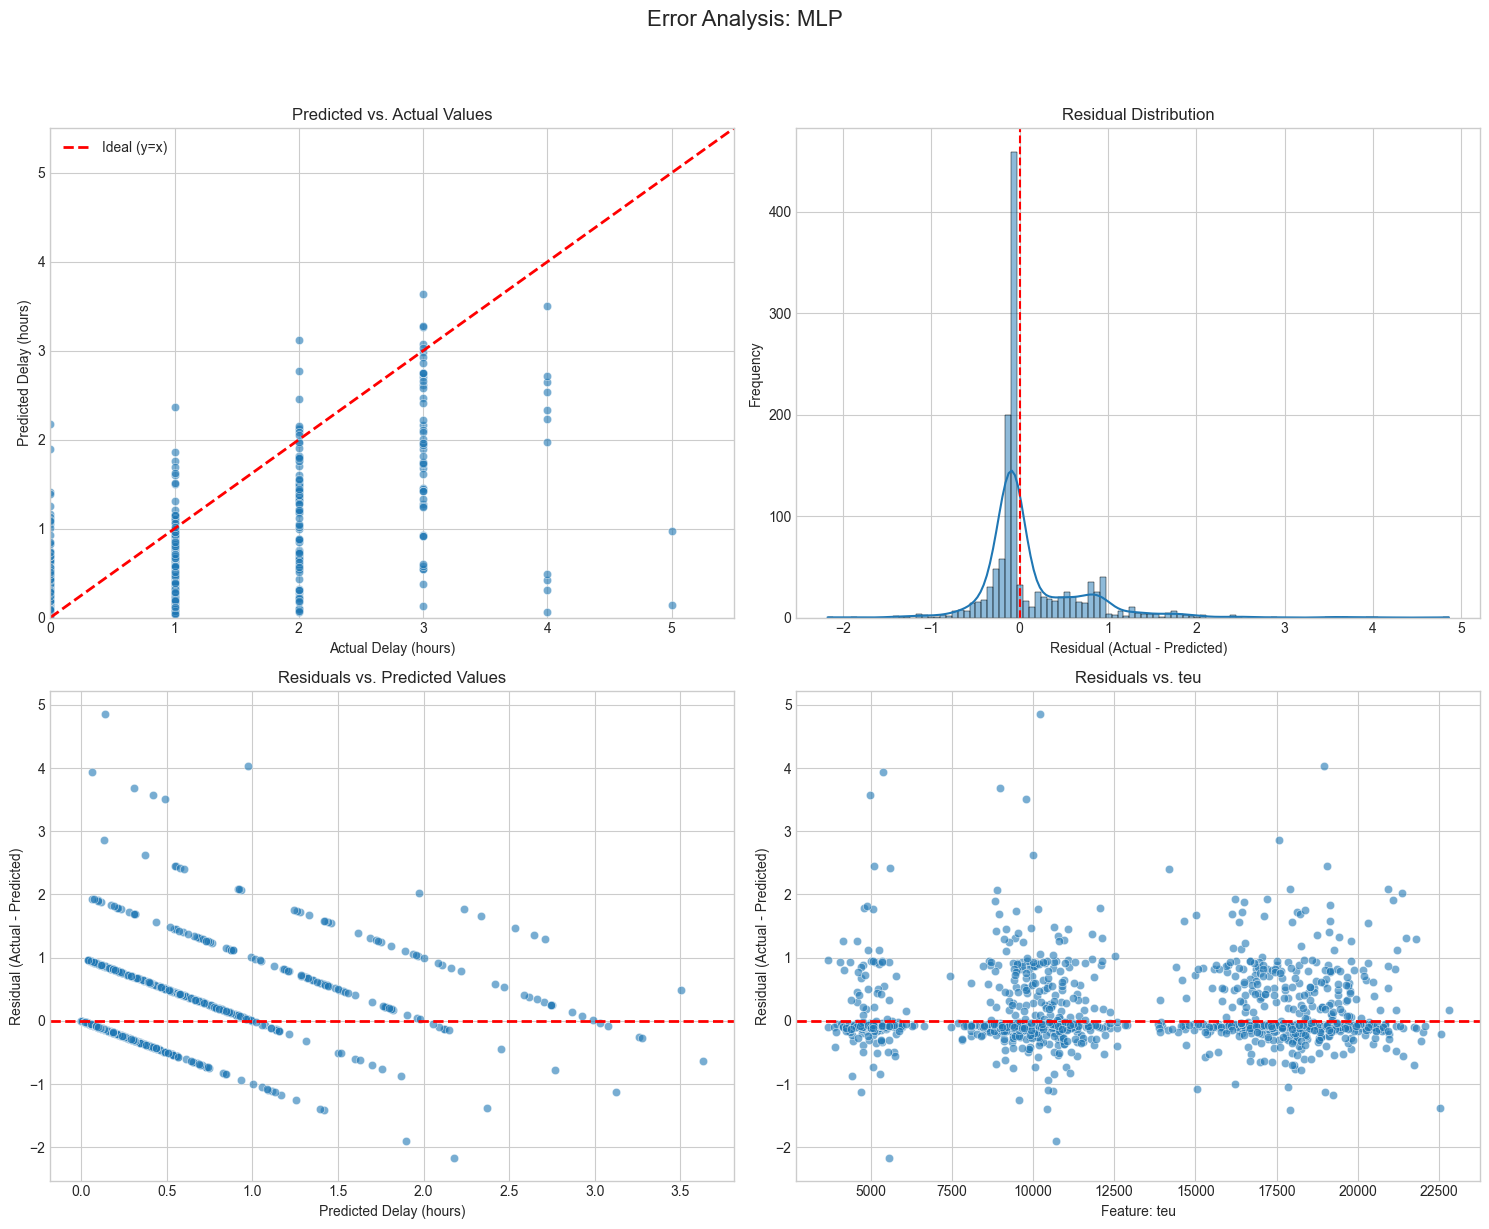


Top 10 Largest Absolute Errors:
      Actual  Predicted  Residual  Abs_Residual
1092     5.0   0.137698  4.862302      4.862302
2254     5.0   0.974327  4.025673      4.025673
3153     4.0   0.059311  3.940689      3.940689
4420     4.0   0.309260  3.690740      3.690740
5272     4.0   0.420311  3.579689      3.579689
2387     4.0   0.487694  3.512306      3.512306
3231     3.0   0.133246  2.866754      2.866754
2836     3.0   0.373686  2.626314      2.626314
2263     3.0   0.547305  2.452695      2.452695
4253     3.0   0.550809  2.449191      2.449191

Features for Largest Errors:
                       type  arrival_hour  arrival_dayofweek  arrival_month  \
1092  Container_PostPanamax             8                  5              3   
2254         Container_ULCS            16                  1              5   
3153      Container_Panamax             6                  0              6   
4420  Container_PostPanamax             3                  2              8   
5272      Cont

In [53]:
analyze_keras_model_errors("MLP", trained_mlp_model, preprocessor.transform(X_test),X_test, y_test)

### RNN

In [54]:
model_data.loc[1547]

vessel_id                                                   V_1489
type                                                Container_ULCS
teu                                                   19794.427948
arrival_time                                           1980.568064
entry_permit_time                                      1980.568064
                                                 ...              
T_predict                            2023-03-23 12:34:05.029867791
num_waiting_entry_at_pred_time                                   0
num_waiting_berth_at_pred_time                                   2
num_at_berth_at_pred_time                                       88
berth_occupancy_rate_at_pred_time                             17.6
Name: 1547, Length: 80, dtype: object


Analyzing RNN Errors

--- Error Analysis for Keras Model: RNN LSTM ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Saved error analysis plot to rnn_lstm_error_analysis.png


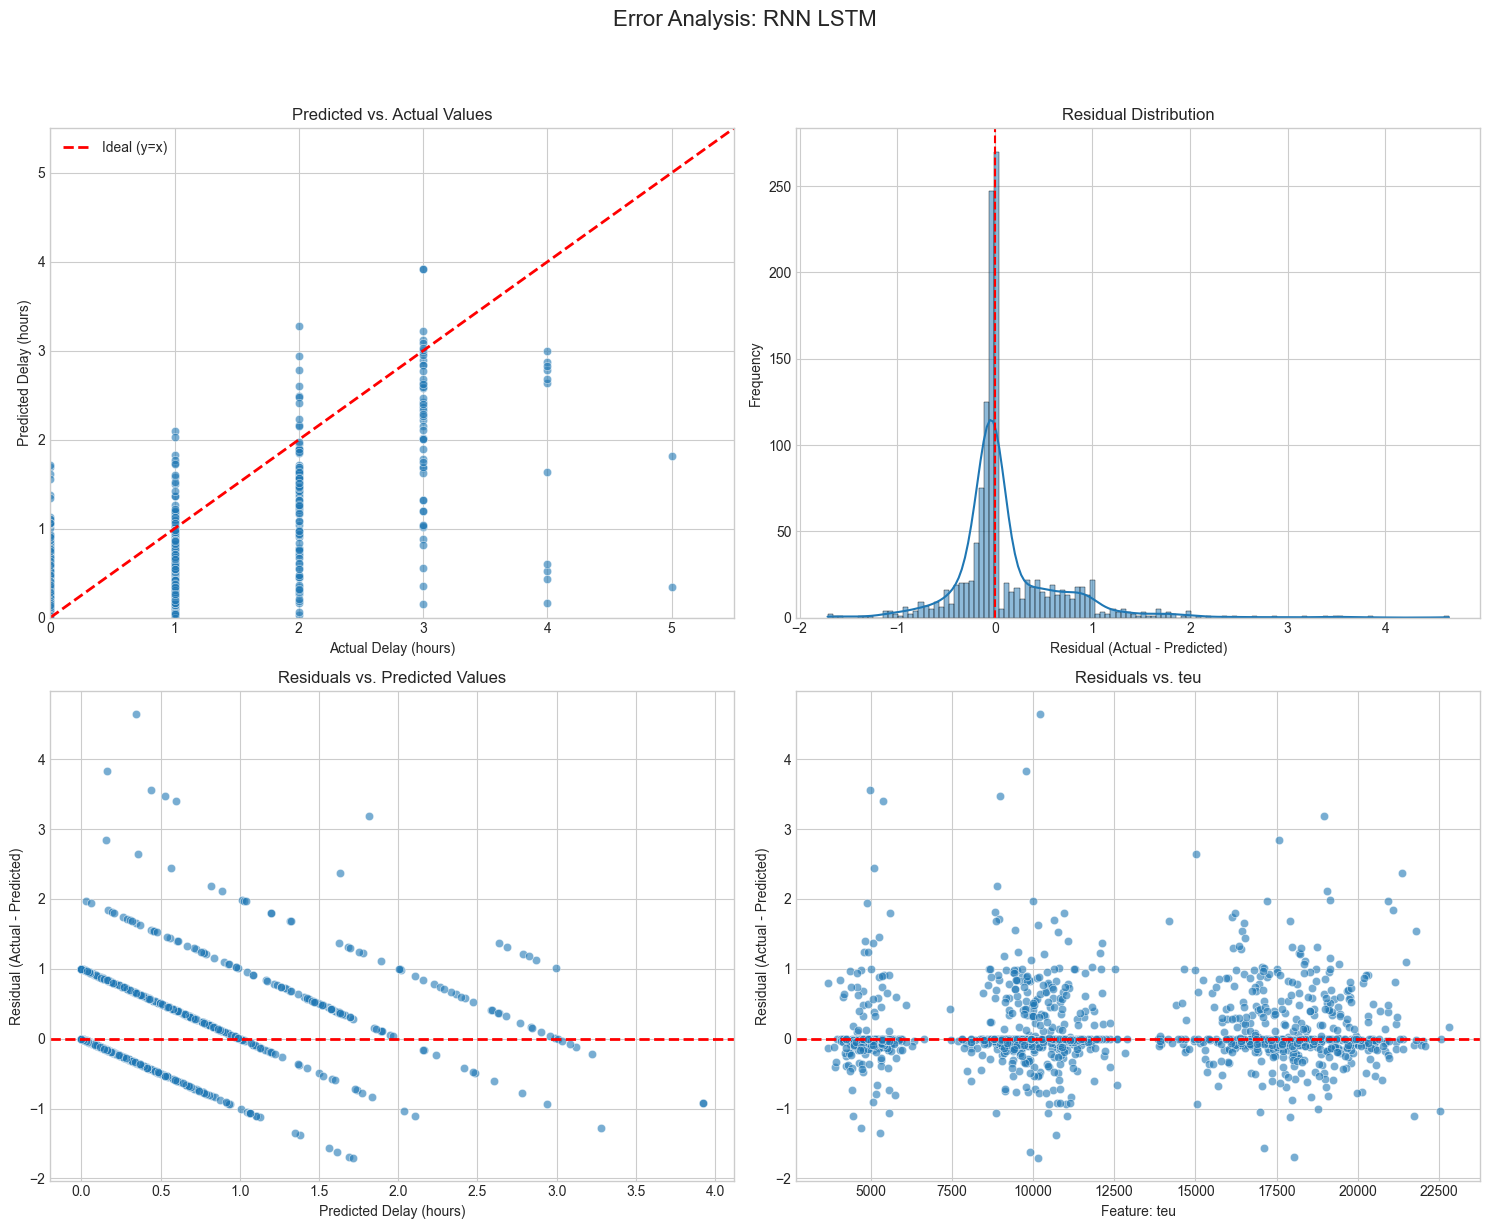


Top 10 Largest Absolute Errors:
      Actual  Predicted  Residual  Abs_Residual
1092     5.0   0.347281  4.652719      4.652719
2387     4.0   0.163429  3.836571      3.836571
5272     4.0   0.438286  3.561714      3.561714
4420     4.0   0.528662  3.471338      3.471338
3153     4.0   0.597148  3.402852      3.402852
2254     5.0   1.817059  3.182941      3.182941
3231     3.0   0.155855  2.844145      2.844145
5330     3.0   0.359652  2.640348      2.640348
2263     3.0   0.562907  2.437093      2.437093
5383     4.0   1.633785  2.366215      2.366215

Features for Largest Errors:
     vessel_id                   type           teu  arrival_time  \
1092    V_1108  Container_PostPanamax  10222.792931   1496.519591   
2387    V_2396  Container_PostPanamax   9775.626680   3191.591521   
5272    V_5323      Container_Panamax   4993.735791   7005.101835   
4420    V_4437  Container_PostPanamax   8986.394651   5787.824863   
3153    V_3205      Container_Panamax   5368.285496   4230.11173

In [55]:
X_test_original_for_seq = model_data.loc[original_test_indices].drop(columns=[TARGET_COLUMN], errors='ignore')
# 2. Processed test data for RNN/CNN
X_test_processed_rnn_cnn = [X_test_seq, X_test_static_proc] # List expected by model.predict

# 3. Target variable for RNN/CNN test set
y_test_for_rnn_cnn = y_test_seq # This is the correct target


# --- Call the Analysis Function ---

print("\n" + "="*30 + "\nAnalyzing RNN Errors\n" + "="*30)
# Analyze RNN
if 'trained_rnn_model' in locals() and trained_rnn_model is not None:
     analyze_keras_model_errors(
         "RNN LSTM",
         trained_rnn_model,
         X_test_processed_rnn_cnn, # Pass the list [seq, static]
         X_test_original_for_seq,  # Pass ORIGINAL features corresponding to test sequence samples
         y_test_for_rnn_cnn        # Pass y_test corresponding to sequence data
     )
else:
    print("Skipping RNN error analysis: Model not trained or available.")


### CNN


Analyzing CNN Errors

--- Error Analysis for Keras Model: CNN 1D ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Saved error analysis plot to cnn_1d_error_analysis.png


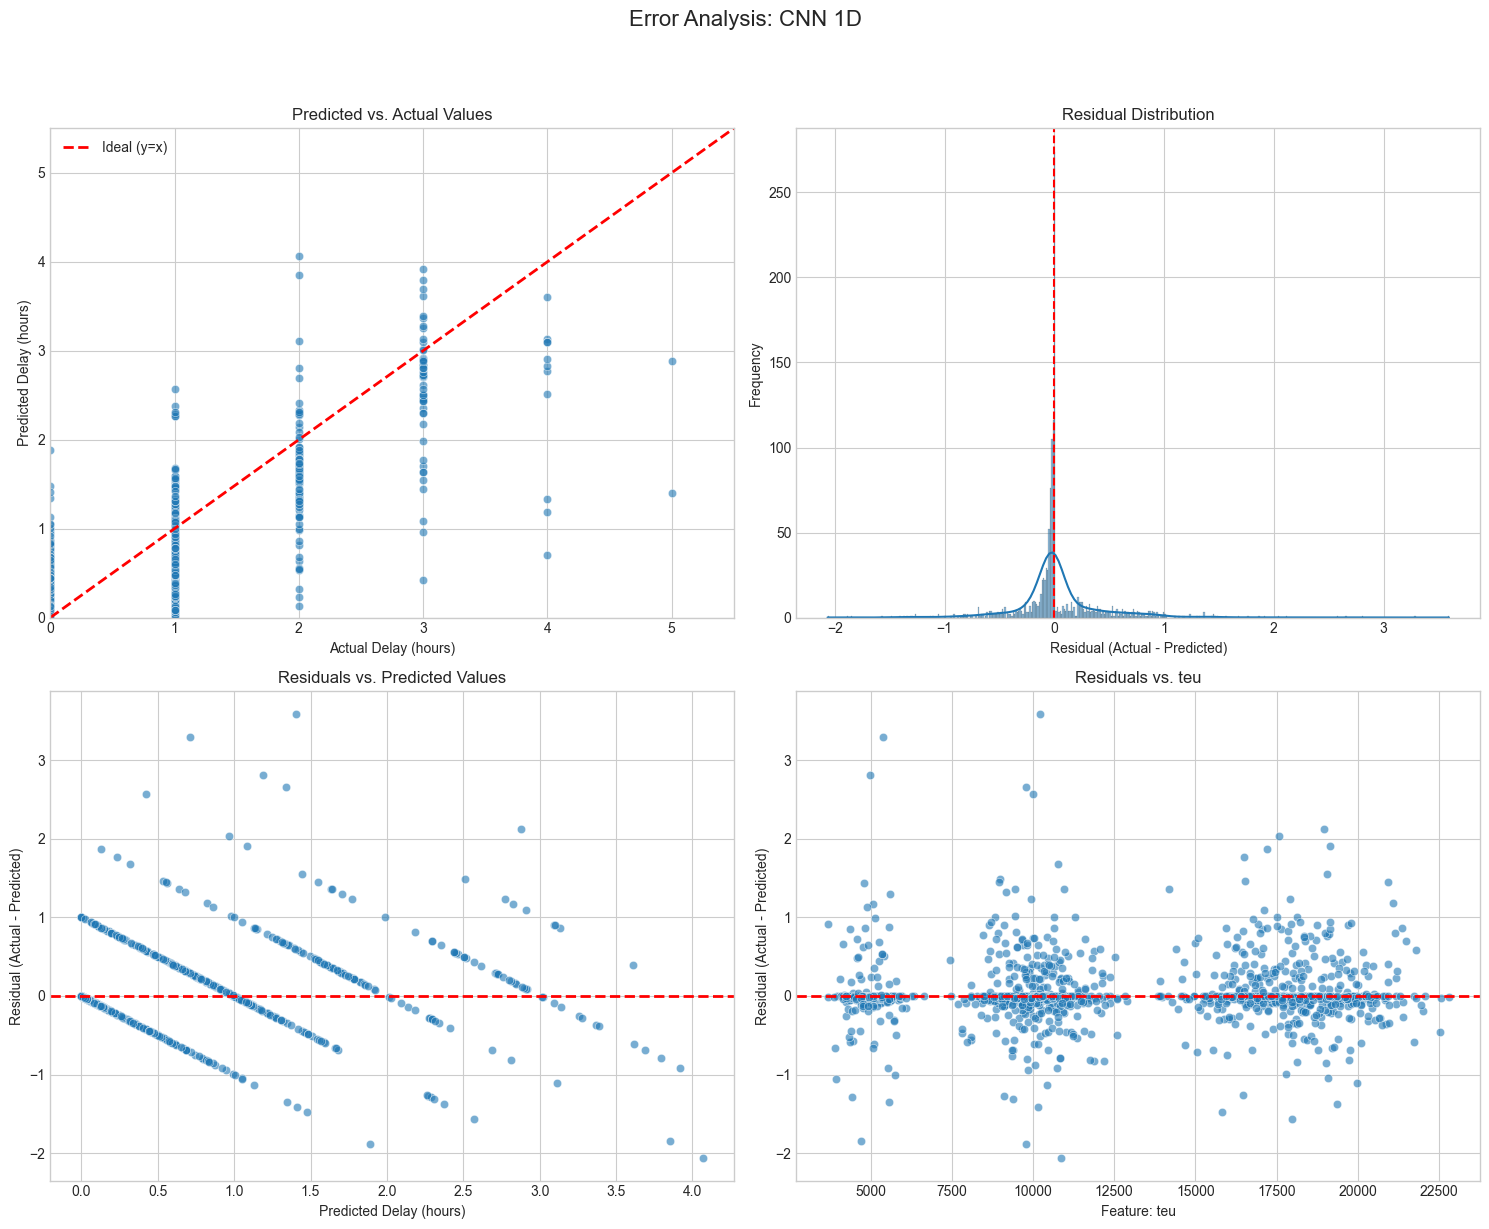


Top 10 Largest Absolute Errors:
      Actual  Predicted  Residual  Abs_Residual
1092     5.0   1.404993  3.595007      3.595007
3153     4.0   0.708179  3.291821      3.291821
5272     4.0   1.186848  2.813152      2.813152
2387     4.0   1.338506  2.661494      2.661494
2836     3.0   0.422735  2.577265      2.577265
2254     5.0   2.879436  2.120564      2.120564
6075     2.0   4.067346 -2.067346      2.067346
3231     3.0   0.963299  2.036701      2.036701
4347     3.0   1.085621  1.914379      1.914379
3583     0.0   1.887527 -1.887527      1.887527

Features for Largest Errors:
     vessel_id                   type           teu  arrival_time  \
1092    V_1108  Container_PostPanamax  10222.792931   1496.519591   
3153    V_3205      Container_Panamax   5368.285496   4230.111731   
5272    V_5323      Container_Panamax   4993.735791   7005.101835   
2387    V_2396  Container_PostPanamax   9775.626680   3191.591521   
2836    V_2857  Container_PostPanamax  10013.416665   3771.94861

In [56]:
print("\n" + "="*30 + "\nAnalyzing CNN Errors\n" + "="*30)
# Analyze CNN
if 'trained_cnn_model' in locals() and trained_cnn_model is not None:
     analyze_keras_model_errors(
         "CNN 1D",
         trained_cnn_model,
         X_test_processed_rnn_cnn, # Pass the list [seq, static]
         X_test_original_for_seq,  # Pass ORIGINAL features corresponding to test sequence samples
         y_test_for_rnn_cnn        # Pass y_test corresponding to sequence data
     )
else:
    print("Skipping CNN error analysis: Model not trained or available.")